# Fit a single XGBoost model and calculate the SHAP values

**Research question: What is the relationship between the SHAP value and feature value?**

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebook (03_xgb_combined_shap_key_features.ipynb) we looked at SHAP values for all the features (fitting models to k-fold data and comparing the differences of the SHAP values obtained across the 5 models). Here we will fit a single model to all of the data (no test set), calculate the SHAP values for this model and focus on understanding the relationship between the SHAP value and feature values for all of the features. We will also calculate the impact (in odds) that a change in feature value has on the likelihood of receiving thrombolysis.

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

## Model and data

XGBoost model was trained on all of the data (no test set used). The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data (no test set) to predict whether patient gets thrombolysis
* Calculate the SHAP values of the features
* Understand the relationship between SHAP values and feature values for each feature (using violin plots, histograms and descriptive text about the impact (in odds) that a change in feature value has on the likelihood of receiving thrombolysis)

## Observations
* Stroke type: The SHAP values for stroke type show that the model effectively eliminated any probability of receiving thrombolysis for non-ischaemic (haemorrhagic) stroke.
*  Arrival-to-scan time: The odds of receiving thrombolysis reduced by about 20 fold over the first 100 minutes of arrival to scan time.
* Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again with higher stroke severity (NIHSS above 25). The difference between minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving thrombolysis was 30-35 fold.
* Stroke onset time type (precise vs. estimated): The odds of receiving thrombolysis were about 3 fold greater for precise onset time than estimated onset time.
* Disability level (mRS) before stroke: The odds of receiving thrombolysis fell about 5 fold between mRS 0 and 5.



## Comparing the SHAP value for patients that attend a hospital, with the SHAP value for patients that do not attend a hospital

[Representing categorical features as one-hot encoded features in the model and keeping them separate for their SHAP value]

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebook (03_xgb_combined_shap_key_features.ipynb) we looked at SHAP values for all the features (fitting models to k-fold data and comparing the differences of the SHAP values obtained across the 5 models). Here we will fit a single model to all of the data (no test set) and focus on understanding the SHAP values for each of the one-hot encoded hosptial features that make up the *Stroke team* categorical feature.

For example, what is the range of SHAP values for patients that attend the hospital, and for those that do not (as we have seen that the hospital has a SHAP value when a patient attend another one, so there is a contribution to the prediction based on *not* attending a hospital). 

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we fit an XGBoost model to the SAMueL dataset, to predict whether a patient recieves thrombolysis from the values of ten features. We calculate the SHAP values of this fitted model and explore the SHAP values for each of the one-hot encoded hospital features.


In our previous notebook (03a_xgb_combined_shap_key_features.ipynb) we fited a single model to all of the data (no test set) and focused on understanding the SHAP values for each of the one-hot encoded hosptial features that make up the *Stroke team* categorical feature.

Here we read in an already fitted XGBoost model to the SAMueL dataset (and the SHAP values), to predict whether a patient recieves thrombolysis from the values of 10 features, using all data to train (no test set). We explore the relationship between SHAP values and feature values for all of the features.




## Observations
* SHAP values for the one-hot encoded hospital features are very dependent on whether the instance attended the hospital or not
* SHAP values for the attended one-hot encoded hospital feature are largely one side of zero or the other. There are fewer instances in this population, but the range of SHAP values is wider.
* SHAP values for the not attended one-hot encoded hospitals are largely centred on zero. There are more instances in this population, but the range of SHAP values is narrower.
* 58% of the variability in hospital thrombolysis rate can be explained by the SHAP value for the one-hot encoded hospital feature (the mean of those instances that attend the hospital).


## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import machine learning methods
from xgboost import XGBClassifier

from os.path import exists

import shap

from scipy import stats

import os
import pickle
import json

# .floor and .ceil
import math

# So can take deep copy
import copy

## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03a'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Get list of feature names

Before convert stroke team to one-hot encoded features.

In [7]:
feature_names = list(test_data_kfold[0])

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [8]:
X = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [9]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


### One-hot encode hospital feature

In [10]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

### Get model feature names 
With one-hot encoded hospitals

In [11]:
# Get a list of the model feature names
feature_names_ohe = list(X.columns)

## Fit XGBoost model

An XGBoost model is trained on the full dataset (rather than train/test splits used to assess accuracy).

Use learning rate 0.5 to regularise the model. Increasing the learning rate value, increases the regularisation. Using a learning rate of 0.5 gives maximum variation between the hosptials. The default learning rate of 0.1 results in few differences between the hospitals (with eight of the one-hot encoded hospital features were not being used in the model - they each had a 0 SHAP value for all of the instances).

See https://samuel-book.github.io/samuel_shap_paper_1/xgb_with_feature_selection/91_learning_rate_optimisation.html?highlight=learning%20rate

In [12]:
filename = (f'./saved_models/{notebook}_{model_text}.p')
# Check if exists
file_exists = exists(filename)

if file_exists:
    # Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
        
else:
    # Define and Fit model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
    model.fit(X, y)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(model, filehandler)

# Get the predictions for each patient 
#   (the classification, and the probability of being in either class)
y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)

# Calculate the models accuracy
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.878


## SHAP values

SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.

### Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Once set up, we can use this explainer to calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

Setup method to estimate SHAP values (in their default units: log odds)

In [13]:
%%time
# Set up method to estimate SHAP values for tree models and ensembles of trees

filename = f'./output/{notebook}_{model_text}_shap_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP explainer
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Set up method to estimate SHAP values for tree models & ensembles of trees
    explainer = shap.TreeExplainer(model)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

CPU times: user 322 ms, sys: 883 ms, total: 1.21 s
Wall time: 106 ms


Setup method to estimate SHAP values as a probability

In [14]:
%%time
# Set up method to estimate SHAP values for tree models and ensembles of trees    

filename = (f'./output/'
            f'{notebook}_{model_text}_shap_explainer_object_probability.p')
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer_probability = pickle.load(filehandler)
else:
    explainer_probability = shap.TreeExplainer(model, X, 
                                               model_output='probability')

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer_probability, filehandler)

CPU times: user 188 ms, sys: 432 ms, total: 620 ms
Wall time: 119 ms


Calculate the SHAP values

In [15]:
%%time
# Get/calculate SHAP values
filename = f'./output/{notebook}_{model_text}_shap_values_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values = pickle.load(filehandler)
else:
    # Get SHAP values
    shap_values = explainer(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values , filehandler)

CPU times: user 16.4 ms, sys: 51.1 ms, total: 67.5 ms
Wall time: 169 ms


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [16]:
shap_values[0]

.values =
array([ 7.56502628e-01,  4.88319576e-01,  1.10273695e+00,  4.40223962e-01,
        4.98975307e-01,  2.02812225e-01, -2.62601525e-01,  3.69181409e-02,
        2.30234995e-01,  3.20923195e-04, -6.03703642e-03, -7.17267860e-04,
        0.00000000e+00, -4.91688668e-04,  1.20360847e-03,  1.77788886e-03,
       -4.34198463e-03, -2.76021136e-04, -2.79896380e-03,  3.52182891e-03,
       -2.73969141e-04,  8.53505917e-03, -5.28220041e-03, -8.25227005e-04,
        6.20208494e-03,  6.92215608e-03, -6.32244349e-03, -3.35367222e-04,
        7.81939551e-03, -4.71850217e-06, -4.25534381e-05,  6.48253039e-03,
        8.43156071e-04, -6.28353562e-04, -1.25156669e-02, -7.92063680e-03,
       -1.99409085e-03, -5.05548809e-03, -3.90118686e-03,  1.30317558e-03,
        0.00000000e+00, -6.48246554e-04,  1.19629130e-03,  8.26304778e-04,
        1.28053436e-02,  2.55714403e-03, -3.20375757e-03,  4.23251512e-03,
       -7.19791185e-03,  4.02670400e-03,  3.75146419e-03,  8.31848301e-04,
        3.45067

There is one of these for each instance.

In [17]:
shap_values.shape

(88792, 141)

#### Calculate average SHAP values for each feature (across all the patients)

Calculate the mean SHAP value for each feature (across all instances), in three ways:
* mean of raw values
* mean of absolute values
* absolute of mean of raw values

(Will use mean |SHAP| to rank the features to determine the order of features for the violin plots)

In [ ]:
# Get SHAP values
shap_values = shap_values_extended.values

# Calculate mean SHAP value for each feature (across all instances)
df_shap_values_mean = pd.DataFrame(index=feature_names_ohe)
df_shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
df_shap_values_mean['abs_mean_shap'] = np.abs(df_shap_values_mean['mean_shap'])
df_shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df_shap_values_mean['rank'] = df_shap_values_mean['mean_abs_shap'].rank(
    ascending=False).values
df_shap_values_mean.sort_values('rank', inplace=True, ascending=True)
df_shap_values_mean.head(10)

Take order of the first 9 features (assuming that all of the teams one-hot encoded features are ranked below the other features).

In [ ]:
features_shap_ranked = list(df_shap_values_mean.head(9).index)

### Violin plots show the relationship between feature value and SHAP value for all of the features

Output descriptive text to use in the paper to describe the differences a feature value had on the likelihood of receiving thromboylsis.

Resource: 
https://towardsdatascience.com/binning-records-on-a-continuous-variable-with-pandas-cut-and-qcut-5d7c8e11d7b0
https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html

In [ ]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation

    reeturn [matplotlib axis object]
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=10)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

Create violin plot and descriptive text

In [ ]:
# Feature Age needs special consideration. It needs the x ticks to be created,
# as the other features with over 50 unique values, but age is already grouped 
# for the model (into 5yr groups) and so is treated as the other type.

# Create figure
fig = plt.figure(figsize=(12,14), constrained_layout=True)
# A subplot showing violin plot for each feature.
# First prepare the fature data for the violin plot: if feature has more than 
# 50 unique values then assume it needs to be binned (a violin for each bin)

# Determine number of rows of subplots by rounding up
nrows = math.ceil(len(features_shap_ranked)/4)

# Through each feature
for n, feat in enumerate(features_shap_ranked):    
    
    # Get data adn SHAP values
    feature_data = shap_values_extended[:, feat].data
    feature_shap = shap_values_extended[:, feat].values

    # If feature has more that 50 unique values, then assume it needs to be 
    # binned (otherwise assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data, create a violin per bin
        
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = min(11, np.int((feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list = [f'{i*step}-{((i+1)*step-1)}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                              right=False)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 90
        
        # create list of unique categories in the feature data
        # Age needs to keep its decimal value (midpoint between 5 yrs)
        category_list = np.unique(feature_data)
        if feat != 'Age':
            category_list = [int(i) for i in category_list]

    # create a list, each entry contains the corresponsing SHAP value for that 
    # category (or bin). A violin will represent each list.    
    shap_per_category = []
    for category in category_list:
        mask = feature_data == category
        shap_per_category.append(feature_shap[mask])

    # Output descriptive text to use in the paper to describe the differences a 
    # feature value had on the likelihood of receiving thromboylsis.
    if feat == "Infarction":
        range_shap_log_odds = np.mean(shap_per_category[1]) - np.mean(shap_per_category[0])
        odds = math.exp(range_shap_log_odds)
        print(f"Stroke type: The SHAP values for stroke type show that the \n"
              f"model effectively eliminated any probability of receiving \n"
              f"thrombolysis for non-ischaemic (haemorrhagic) stroke. The \n"
              f"odds of receiving thrombolysis fell about {round(odds,2)} \n"
              f"fold.\n")    
    if feat == "Arrival-to-scan time":
        range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[3])
        odds = math.exp(range_shap_log_odds)
        print(f"Arrival-to-scan time: The odds of receiving thrombolysis reduced by \n"
        f"about {round(odds,2)} (20) fold over the first 120 minutes of arrival to scan time.\n")    
    if feat == "Stroke severity":
        range_shap_log_odds = np.mean(shap_per_category[19]) - np.mean(shap_per_category[0])
        odds = math.exp(range_shap_log_odds)
        print(f"Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest\n"
          f" at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again \n"
          f"with higher stroke severity (NIHSS above 25). The difference between \n"
          f"minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving \n"
          f"thrombolysis was {round(odds,2)} (30-35) fold.\n")
    if feat == "Precise onset time":
        range_shap_log_odds = np.mean(shap_per_category[1]) - np.mean(shap_per_category[0])
        odds = math.exp(range_shap_log_odds)
        print(f"Stroke onset time type (precise vs. estimated): The odds of receiving \n"
          f"thrombolysis were about {round(odds,2)} (3) fold greater for precise onset time than \n"
          f"estimated onset time.\n")
    if feat == "Prior disability level":
        range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[5])
        odds = math.exp(range_shap_log_odds)
        print(f"Disability level (mRS) before stroke: The odds of receiving \n"
        f"thrombolysis fell about {round(odds,2)} (5) fold between mRS 0 and 5.\n")
    if feat == "Use of AF anticoagulants":
        range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[1])
        odds = math.exp(range_shap_log_odds)
        print(f"Use of AF anticoagulants: The odds of receiving thrombolysis were about\n"
        f" {round(odds,2)} fold greater for no use.\n")
    if feat == "Onset-to-arrival time":
        range_shap_log_odds = np.mean(shap_per_category[4]) - np.mean(shap_per_category[7])
        odds = math.exp(range_shap_log_odds)
        print(f"Onset-to-arrival time: The odds of receiving thrombolysis were similar \n"
        f"below 120 minutes, then fell about {round(odds,2)} fold between 120 and above.\n")
    if feat == "Age":
        range_shap_log_odds = np.mean(shap_per_category[13]) - np.mean(shap_per_category[17])
        odds = math.exp(range_shap_log_odds)
        print(f"Age: The odds of receiving thrombolysis were similar below 80 years \n"
        f"old, then fell about {round(odds,2)} fold between 80 and 120 years old.\n")
    if feat == "Onset during sleep":
        range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[1])
        odds = math.exp(range_shap_log_odds)
        print(f"Onset during sleep: The odds of receiving thrombolysis were about \n"
        f"{round(odds,2)} fold lower for onset during sleep.\n")

    if feat == 'Age':
        # create text of x ticks
        category_list = [f'{int(i-2.5)}-{int(i+2.5)}' for i in category_list]

        # SSNAP dataset had oldest age category as 100-120 (not a 5 yr band as 
        #   the other ages). To accommodate this, if last age category is "110"
        #   then overwrite the label with the correct band (100-120), and not
        #   107-112 as the above code would create.
        if category_list[-1] == '107-112':
            category_list[-1] = '100-120'
            
    # create violin plot
    ax = fig.add_subplot(nrows,3,n+1)
    
    ax.violinplot(shap_per_category, showmeans=True, widths=0.9)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([0, len(feature_values)], [0,0],c='0.5')   

    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    
    # Adjust stroke severity tickmarks
    if feat == 'Stroke severity':
        ax.set_xticks(np.arange(1, len(category_list)+1, 2))
        ax.set_xticklabels(category_list[0::2])   
    
    # Add title
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
    
fig.savefig(f'output/{notebook}_{model_text}_thrombolysis_shap_violin_all_'
            f'features.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()

### Compare SHAP values for the hospital one-hot encoded features

The hospital feature is one-hot encoded, so there is a SHAP value per stroke team. We will use this to create a histogram of the frequency of the SHAP value for the hospital feature (take the mean of the SHAP values for the instances for each hospital's own patients).

In [ ]:
# Set up list for storing patient data and hospital SHAP
feature_data_with_shap = []

# Get mean SHAP for stroke team when patient attending that stroke team
unique_stroketeams_list = list(np.unique(data['Stroke team']))
stroke_team_mean_shap = []
# Loop through stroke teams
for stroke_team in unique_stroketeams_list:
    # Identify rows in test data that match each stroke team
    mask = data['Stroke team'] == stroke_team
    stroke_team_shap_all_features = shap_values[mask]
    # Get column index for stroke_team_in_shap
    feature_name = 'team_' + stroke_team
    index = feature_names_ohe.index(feature_name)
    # Get SHAP values for hospital
    stroke_team_shap = stroke_team_shap_all_features[:, index]
    # Get mean
    mean_shap = np.mean(stroke_team_shap)
    # Store mean
    stroke_team_mean_shap.append(mean_shap)
    # Get and store feature data and add SHAP
    feature_data = data[mask]
    feature_data['Hospital_SHAP'] = stroke_team_shap
    feature_data_with_shap.append(feature_data)

# Concatenate and save feature_data_with_shap
feature_data_with_shap = pd.concat(feature_data_with_shap, axis=0)
feature_data_with_shap.to_csv(
   f'./predictions/{notebook}_{model_text}_feature_data_with_hospital_shap.csv', 
    index=False)

# Create and save shap mean value per hospital
hospital_data = pd.DataFrame()
hospital_data["stroke_team"] = unique_stroketeams_list
hospital_data["shap_mean"] = stroke_team_mean_shap
hospital_data.to_csv(
    f'./predictions/{notebook}_{model_text}_mean_shap_per_hospital.csv', 
    index=False)

In [ ]:
hospital_data

#### Use same colour scheme as violin plot (for paper)
 
Code used to get colour of violin plots
Resource: https://stackoverflow.com/questions/26291479/changing-the-color-of-matplotlibs-violin-plots

In [ ]:
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
vp = ax.violinplot(shap_per_category, showmeans=True, widths=0.9)

for vp1 in vp['bodies']:
    facecolor = vp1.get_edgecolor()
    edgecolor = vp['cmeans'].get_colors()

#### Plot histogram using color scheme from violin plots
* facecolor = [0.12156863, 0.46666667, 0.70588235, 0.3]
* edgecolor= [0.12156863, 0.46666667, 0.70588235, 1.]

Plot histogram of the frequency of the mean SHAP value for the instances for each hospital's own patients

In [ ]:
# Plot histogram
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot()

ax.hist(stroke_team_mean_shap, bins=np.arange(-1.5, 1.5, 0.1), 
        color=[0.12156863, 0.46666667, 0.70588235, 0.3], 
        ec=[0.12156863, 0.46666667, 0.70588235, 1.], 
        linewidth=1.4)

ax.set_xlabel('SHAP values for one-hot encoded hospital features')
ax.set_ylabel('Count')
plt.savefig(f'./output/{notebook}_{model_text}_hosp_shap_hist.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

Output descriptive text to use in the paper to describe the differences the hospitalfeature value had on the likelihood of receiving thromboylsis.
Convert from log odds to odds.

In [ ]:
range_shap_log_odds = max(stroke_team_mean_shap) - min(stroke_team_mean_shap)
odds = math.exp(range_shap_log_odds)
print(f"There was a {round(odds,2)} fold difference in odds of receiving thrombolysis between hospitals")

### Understand SHAP values for the one-hot encoded hospital features 

We've seen above that the categorical feature represented as a one-hot encoded feature have a SHAP value for each of the one-hot encoded features.

For the hospital that the instance attends, the SHAP value for that hosptial represents "the contribution to the prediction due to attending this hospital". For all of the other hosptials for this instance, the SHAP value for those hospitals represents "the contribution to the prediction from not attending this hospital". 

Here we will focus on understanding the SHAP values for each hospital, their contribution when a patient attends the hospital, and the contribution when the patient does not attend the hospital.

#### Format the data 

Features are in the same order in shap_values as they are in the original dataset.

Use this to extract the SHAP values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

In [18]:
# Get list of one-hot encoded hospital column titles
hospital_names_ohe = X.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names = [h[5:] for h in hospital_names_ohe]

# Create list of column indices for these hospital column titles (where do the
#   hospital features exist in the datasets?)
hospital_columns_index = [X.columns.get_loc(col) for col in hospital_names_ohe]
# Use this index list to access the hosptial shap values (as array)
hosp_shap_values = shap_values.values[:,hospital_columns_index]
# Put in dataframe with hospital as column title
df_hosp_shap_values = pd.DataFrame(hosp_shap_values, columns = hospital_names)

Also include four further columns:
1) the hospital that the instance attended
2) contribution from all of the one-hot encoded hospital features
3) contribution from just the hospital attended
4) contribution from not attending the rest

In [19]:
# Include Stroke team that each instance attended
df_hosp_shap_values["Stroke team"] = X_combined["Stroke team"].values

# Store the sum of the SHAP values (for all of the hospital features)
df_hosp_shap_values["all_stroke_teams"] = df_hosp_shap_values.sum(axis=1)

# Initialise list for 1) SHAP value for attended hospital 2) SHAP value for 
#   the sum of the rest of the hospitals
shap_attended_hospital = []
shap_not_attend_these_hospitals = []

# For each patient
for index, row in df_hosp_shap_values.iterrows():

    # Get stroke team attended
    stroke_team = row["Stroke team"]
    
    # Get SHAP value for the stroke team attended
    shap_attended_hospital.append(row[stroke_team])

    # Calculate sum of SHAP values for the stroke teams not attend 
    sum_rest = row["all_stroke_teams"] - row[stroke_team]
    shap_not_attend_these_hospitals.append(sum_rest)

# Store two new columns in dataframe
df_hosp_shap_values["attended_stroke_team"] = shap_attended_hospital
df_hosp_shap_values["not_attended_stroke_teams"] = (
                                            shap_not_attend_these_hospitals)
                   
# View preview
df_hosp_shap_values.head()

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,Stroke team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,0.000321,-0.006037,-0.000717,0.0,-0.000492,0.001204,0.001778,-0.004342,-0.000276,-0.002799,...,0.000720,0.000683,-0.001920,0.002390,-0.000897,0.004855,TXHRP7672C,-0.084398,-0.023110,-0.061287
1,0.001207,-0.002507,0.000081,0.0,-0.001356,0.001547,0.003449,-0.006348,-0.000127,-0.002576,...,0.000148,0.000683,-0.001825,0.000454,-0.001445,0.003970,SQGXB9559U,-0.760522,-0.671515,-0.089007
2,0.001492,-0.015246,0.002635,0.0,-0.000272,0.001399,0.002737,-0.007848,-0.000605,-0.002614,...,0.000135,0.000262,-0.000928,0.001229,-0.001506,0.003792,LFPMM4706C,-1.204099,-1.084834,-0.119265
3,0.001255,0.002451,0.002644,0.0,-0.001359,0.000008,0.003055,-0.003141,-0.000131,-0.002352,...,0.000705,0.000683,-0.003016,0.003507,-0.000939,0.002133,MHMYL4920B,0.684426,0.737010,-0.052583
4,0.006129,-0.004731,0.002644,0.0,-0.001359,0.000302,0.002677,-0.004384,0.000272,-0.002281,...,0.000892,0.000010,-0.001976,0.001467,-0.000799,0.002244,EQZZZ5658G,-0.088429,0.028813,-0.117242


#### Boxplot (all hospitals together)

Analyse the range of SHAP values for the one-hot encoded hospital features. Show as two populations: 1) the attended hospital, 2) the sum of the hospitals not attended

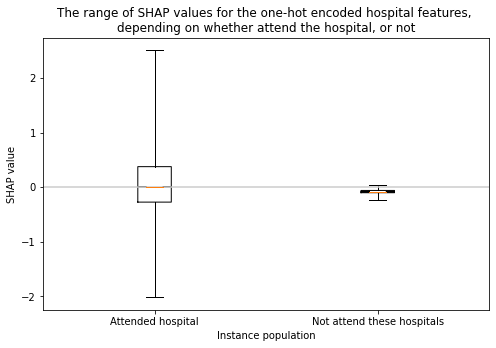

In [20]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.boxplot([shap_attended_hospital, shap_not_attend_these_hospitals],
            labels=["Attended hospital", "Not attend these hospitals"],
            whis=99999, notch=True);
title = ("The range of SHAP values for the one-hot encoded hospital features, "
         "\ndepending on whether attend the hospital, or not")

# Add line at Shap = 0
ax.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    
ax.set_title(title)
ax.set_xlabel("Instance population")
ax.set_ylabel("SHAP value");

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_hosp_shap_attend_vs_notattend_boxplot.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

#### Boxplot (individual hospitals)

Create a boxplot to show the range of SHAP values for each individual one-hot encoded hospital feature. 

Show the SHAP value as two populations: 1) the group of instances that attend the hospital [black], and 2) the group of instances that do not attend the hosptial [orange].

Order the hospitals in descending order of mean SHAP value for the hospital the instance attended (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly, to order the hospitals, create a dataframe containing the mean SHAP value for each hosptial (for those instances that attended the hospital)

In [21]:
# Initialise lists
attend_stroketeam_min = []
attend_stroketeam_q1 = []
attend_stroketeam_mean = []
attend_stroketeam_q3 = []
attend_stroketeam_max = []

# For each hospital, store descriptive statistics of SHAP values for those
#   instances that attend the hospital
for h in hospital_names:
    mask = df_hosp_shap_values['Stroke team'] == h
    data_stroke_team = df_hosp_shap_values[h][mask]
    q1, q3 = np.percentile(data_stroke_team, [25,75])
    attend_stroketeam_min.append(data_stroke_team.min())
    attend_stroketeam_q1.append(q1)
    attend_stroketeam_mean.append(data_stroke_team.mean())
    attend_stroketeam_q3.append(q3)
    attend_stroketeam_max.append(data_stroke_team.max())
    
# Create dataframe with 6 columns
df_hosp_shap_value_stats = pd.DataFrame(hospital_names, columns=["hospital"])
df_hosp_shap_value_stats["shap_min"] = attend_stroketeam_min
df_hosp_shap_value_stats["shap_q1"] = attend_stroketeam_q1
df_hosp_shap_value_stats["shap_mean"] = attend_stroketeam_mean
df_hosp_shap_value_stats["shap_q3"] = attend_stroketeam_q3
df_hosp_shap_value_stats["shap_max"] = attend_stroketeam_max

# sort in descending mean SHAP value order
df_hosp_shap_value_stats.sort_values("shap_mean", ascending=False, inplace=True)                
df_hosp_shap_value_stats.head(5)

,hospital,shap_min,shap_q1,shap_mean,shap_q3,shap_max
9,CNBGF2713O,0.648626,1.160532,1.338743,1.513107,1.989456
25,GKONI0110I,0.046286,0.888337,1.085008,1.286739,1.779779
62,MHMYL4920B,0.130139,0.786147,0.933300,1.059232,1.476519
65,NTPQZ0829K,0.209000,0.763998,0.917956,1.126985,1.599991
32,HPWIF9956L,0.206888,0.652731,0.901027,1.152177,1.624375


Add admission figures to xlabel in boxplot

Create dataframe with admissions and thrombolysis rate per stroke team (index)

In [22]:
# Get Stroke team name, the stroke team admission numbers, and list of SHAP 
#   values for each instance that attended teh stroke team
unique_stroketeams_list = list(set(X_combined["Stroke team"]))
admissions = [X[f'team_{s}'].sum() for s in unique_stroketeams_list]

df_stroketeam_ivt_adms = pd.DataFrame(unique_stroketeams_list, 
                                      columns=["Stroke team"])
df_stroketeam_ivt_adms["Admissions"] = admissions
df_stroketeam_ivt_adms.set_index("Stroke team", inplace=True)
df_stroketeam_ivt_adms.sort_values("Admissions", ascending=True, inplace=True)

# Calculate IVT rate per hosptial
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]

# Join IVT rate with admissions per hosptial
df_stroketeam_ivt_adms = df_stroketeam_ivt_adms.join(hosp_ivt_rate)

df_stroketeam_ivt_adms

,Admissions,Thrombolysis
Stroke team,,
JXJYG0100P,120,0.233333
VVDIY0129H,130,0.192308
YEXCH8391J,149,0.228188
CNBGF2713O,152,0.480263
XPABC1435F,166,0.216867
...,...,...
JINXD0311F,1377,0.368192
AKCGO9726K,1428,0.369748
OFKDF3720W,1488,0.228495


Create data for boxplot. Using order of hospitals from the hosp_shap_stats_df dataframe.

In [23]:
# Go through this order of hospitals
hospital_order = df_hosp_shap_value_stats["hospital"]
    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   attend stroke team
attend_stroketeam_groups_ordered = []
not_attend_stroketeam_groups_ordered = []

# Create list of labels for boxplot "stroke team name (admissions)"
xlabel = []

# Through hospital in defined order (as determined above)
for h in hospital_order:
    # Attend
    mask = df_hosp_shap_values['Stroke team'] == h
    attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Not attend
    mask = df_hosp_shap_values['Stroke team'] != h
    not_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Label
    ivt_rate = int(df_stroketeam_ivt_adms['Thrombolysis'].loc[h] * 100)
    xlabel.append(f"{h} ({df_stroketeam_ivt_adms['Admissions'].loc[h]}, "
                  f"{ivt_rate}%)")

Plot the boxplot

Resource for using overall y min and max of both datasets on the 4 plots so have the same range: https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists

Shows the range of contributions to the prediction from this hospital when patients 1) do [black], and 2) do not [orange] attend this hospital


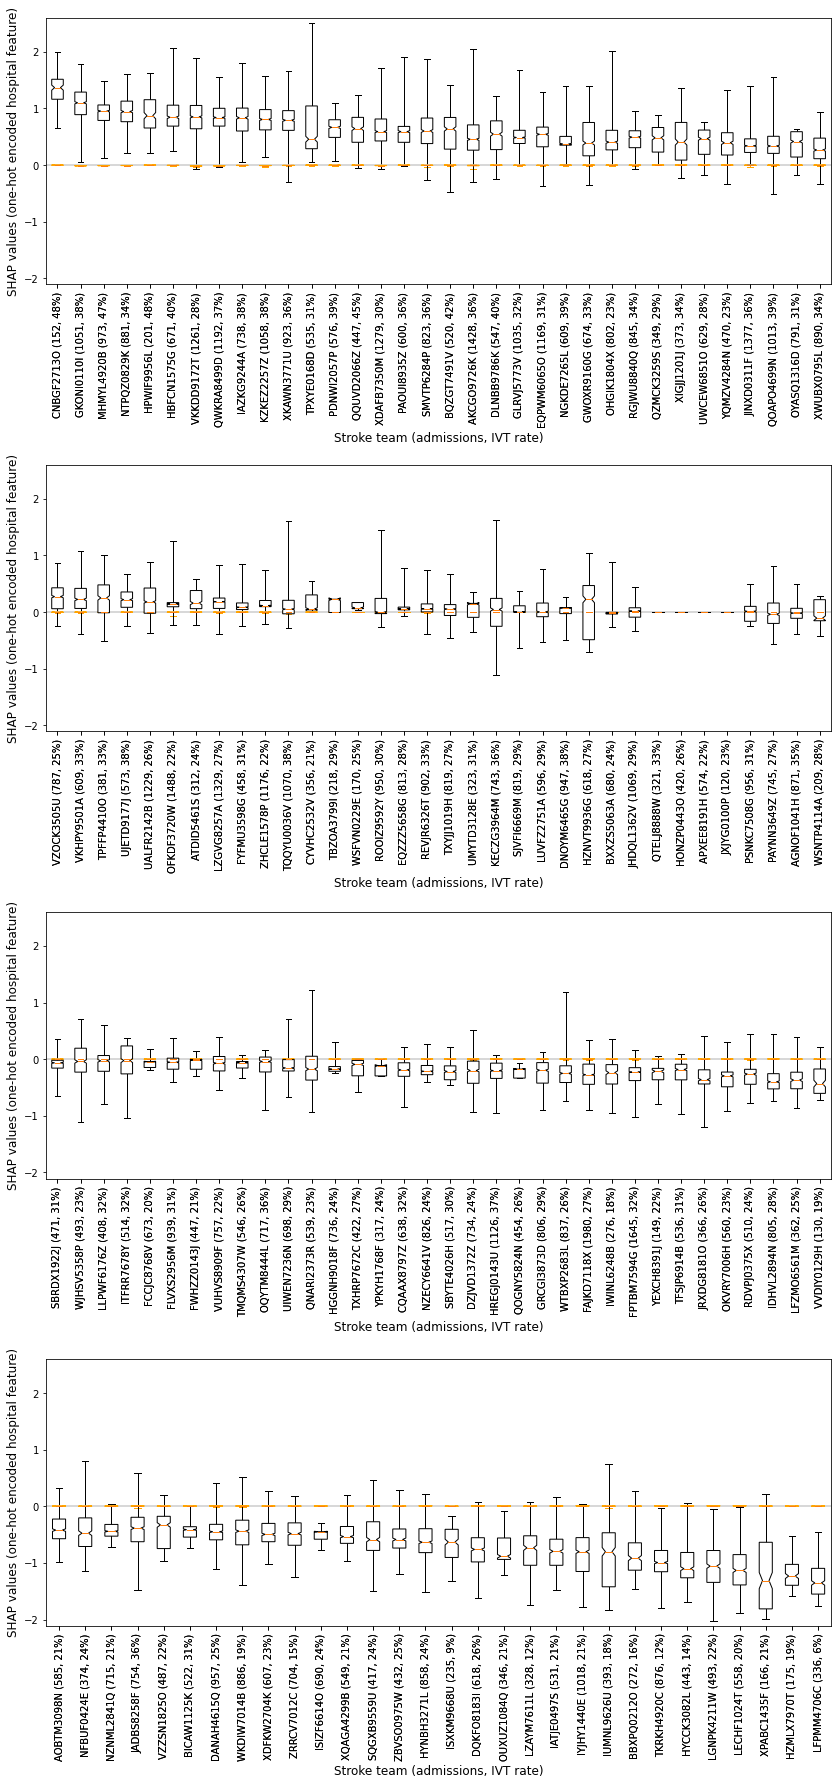

In [24]:
# Plot 34 hospitals on each figure to aid readability
print("Shows the range of contributions to the prediction from this hospital "
      "when patients 1) do [black], and 2) do not [orange] attend this "
      "hospital")

# Group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Use overall y min & max of both datasets on the 4 plots so have same range
ymin1 = min(min(attend_stroketeam_groups_ordered, key=min))
ymin2 = min(min(not_attend_stroketeam_groups_ordered, key=min))
ymax1 = max(max(attend_stroketeam_groups_ordered, key=max))
ymax2 = max(max(not_attend_stroketeam_groups_ordered, key=max))
ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

# Adjust min and max to accommodate some wriggle room
yrange = ymax - ymin1
ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create figure with 4 subplots
fig = plt.figure(figsize=(12,25))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)

    # The contribution from this hospital when patients don't attend this 
    #    hospital
    c1 = "orange"
    c2 = "orange"
    c3 = "white"
    ax.boxplot(not_attend_stroketeam_groups_ordered[st:ed],
               labels=xlabel[st:ed],
               whis=99999, patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               meanprops=dict(color=c2))
       
    # The contribution from this hospital when patients do attend this hosptial
    c1 = "black"
    c2 = "black"
    c3 = "white"
    ax.boxplot(attend_stroketeam_groups_ordered[st:ed],
               labels=xlabel[st:ed],
               whis=99999, patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               meanprops=dict(color=c2))

    plt.ylabel('SHAP values (one-hot encoded hospital feature)',size=12)
    plt.xlabel('Stroke team (admissions, IVT rate)',size=12)
    plt.ylim(ymin, ymax)
    plt.xticks(rotation=90)
    # Add line at Shap = 0
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

plt.subplots_adjust(bottom=0.25, wspace=0.05)
    
plt.tight_layout(pad=2)

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_individual_hosp_shap_attend_vs_notattend_boxplot.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

Notice that when patients do not attend the hospital, the range of the SHAP values are largely centred on zero.
When patients do attend hosptial, the range of SHAP values are largely on one side of zero, or the other.

In [25]:
iqr_below_zero = df_hosp_shap_value_stats["shap_q3"] < 0
iqr_spans_zero = (df_hosp_shap_value_stats["shap_q1"] * 
                  df_hosp_shap_value_stats["shap_q3"])
iqr_above_zero = df_hosp_shap_value_stats["shap_q1"] > 0
iqr_is_zero1 = df_hosp_shap_value_stats["shap_q1"] == 0
iqr_is_zero2 = df_hosp_shap_value_stats["shap_q3"] == 0
iqr_is_zero = iqr_is_zero1 * iqr_is_zero2

print (f"There are {iqr_below_zero.sum()} hospitals whose interquartile range "
       f"is below zero")
print (f"There are {iqr_spans_zero.lt(0).sum()} hospitals whose interquartile "
       f"range spans zero")
print (f"There are {iqr_above_zero.sum()} hospitals whose interquartile range "
       f"is above zero")
print (f"There are {iqr_is_zero.sum()} hospitals whose interquartile range is "
       f"zero")

There are 58 hospitals whose interquartile range is below zero
There are 24 hospitals whose interquartile range spans zero
There are 46 hospitals whose interquartile range is above zero
There are 4 hospitals whose interquartile range is zero


How does the SHAP value for the attended one-hot encoded hospital feature compare to the thrombolysis rate of the hospital?

Create dataframe containing the hospital's IVT rate and SHAP value (for those patients that attend the hospital).

In [26]:
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]
df_hosp_plot = (
        df_hosp_shap_value_stats[["shap_mean","hospital"]].copy(deep=True))
df_hosp_plot.set_index("hospital", inplace=True)
df_hosp_plot = df_hosp_plot.join(hosp_ivt_rate)
df_hosp_plot

,shap_mean,Thrombolysis
hospital,,
CNBGF2713O,1.338743,0.480263
GKONI0110I,1.085008,0.389153
MHMYL4920B,0.933300,0.473792
NTPQZ0829K,0.917956,0.349603
HPWIF9956L,0.901027,0.487562
...,...,...
LGNPK4211W,-1.069179,0.227181
LECHF1024T,-1.097267,0.204301
XPABC1435F,-1.196877,0.216867


Plot SHAP value for one-hot encoded hospital feature (mean for those instances that attend the hospital) vs hospital IVT rate

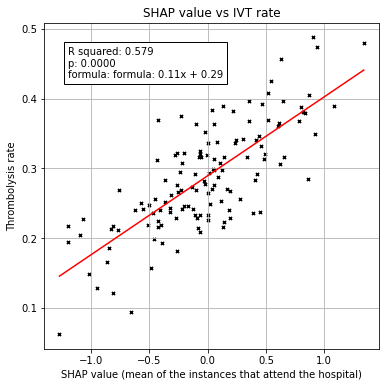

In [27]:
# Setup data for chart
x = df_hosp_plot['shap_mean']
y = df_hosp_plot['Thrombolysis']

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(x, y, color='black', marker='x', s=10)
ax.plot (x, y_pred, color = 'red')
f = ('formula: ' + str("{:.2f}".format(slope)) + 'x + ' + 
     str("{:.2f}".format(intercept)))
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}\nformula: {f}'
ax.text(-1.2, 0.43, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax.set_xlabel("SHAP value (mean of the instances that attend the hospital)")
ax.set_ylabel('Thrombolysis rate')
ax.set_title("SHAP value vs IVT rate")
plt.grid()

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_attended_hosp_shap_vs_ivt_rate.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

# Extra code

There was a journey to analyse the data and arrive at the boxplot (that we found to be the best visualisation yet to summarise this data). 

Below are the other ways that we looked at the data, that led us to use the boxplot.

View descriptive stats

In [28]:
df_hosp_shap_values.describe()

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,XWUBX0795L,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
count,88792.000000,88792.000000,88792.000000,88792.0,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,...,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000
mean,0.001127,-0.002248,-0.000125,0.0,0.000002,-0.000846,0.000121,0.000189,-0.000461,-0.000242,...,-0.000391,-0.000049,-0.000210,0.000426,-0.000371,-0.000114,-0.000647,-0.037682,0.042369,-0.080051
std,0.013528,0.082680,0.039048,0.0,0.015024,0.051438,0.034849,0.050091,0.013646,0.056630,...,0.039715,0.013549,0.011468,0.035839,0.043886,0.020340,0.049949,0.560754,0.549480,0.033426
min,-0.389735,-0.294640,-0.987508,0.0,-0.221226,-1.461526,-0.733899,-0.482234,-0.262650,-0.004530,...,-0.328137,-0.792791,-0.296149,-0.328538,-1.204027,-0.213830,-1.240766,-2.085642,-2.018145,-0.233494
25%,0.000334,-0.015132,0.001455,0.0,-0.000965,0.001333,0.002318,-0.004953,-0.000319,-0.002886,...,-0.004907,0.000204,0.000262,-0.002390,0.001578,-0.002748,0.001935,-0.363692,-0.271972,-0.099802
50%,0.000775,-0.008884,0.002641,0.0,-0.000498,0.001857,0.002737,-0.003369,-0.000220,-0.002531,...,-0.002697,0.000317,0.000262,-0.001799,0.002549,-0.001633,0.003190,-0.064071,0.010659,-0.079233
75%,0.001255,-0.003960,0.003523,0.0,-0.000203,0.002346,0.003449,-0.001076,-0.000080,-0.002174,...,-0.001574,0.000667,0.000683,-0.000900,0.003388,-0.001342,0.004121,0.304690,0.377607,-0.058291
max,0.504174,2.055953,0.329712,0.0,0.592340,0.262388,0.003869,1.405697,0.881546,1.989456,...,0.929842,0.049373,0.000864,1.315028,0.283344,0.744248,0.176605,2.409183,2.507814,0.033592


Are there any hospitals that only have one value for all instances?
This indicates that the feature was not used to divide a node in any of the trees.

In [29]:
print("These hospitals have the same SHAP value for all patients")
for h in hospital_names:
    if df_hosp_shap_values[h].nunique() == 1:
        print(f"{h} has SHAP value {df_hosp_shap_values[h].unique()[0]} for all" 
              f" instances")

These hospitals have the same SHAP value for all patients
APXEE8191H has SHAP value 0.0 for all instances
HONZP0443O has SHAP value 0.0 for all instances
JXJYG0100P has SHAP value 0.0 for all instances
QTELJ8888W has SHAP value 0.0 for all instances


What's the range of number of unique values for each hospital for all patients?

The count of unique SHAP values for each hospital


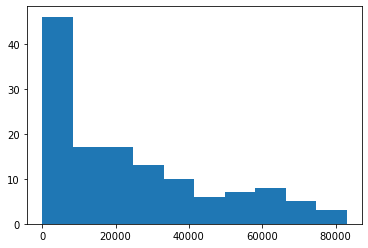

In [30]:
print ("The count of unique SHAP values for each hospital")       
n_unique_per_hosptial = [
                    df_hosp_shap_values[h].nunique() for h in hospital_names]                         
fig, axes = plt.subplots(1)
axes.hist(n_unique_per_hosptial);

Is there a relationship between number of unique SHAP values, and hospital admission numnbers?

In [31]:
# Calculate the number of admissions per hospital
admissions = [X[h].sum() for h in hospital_names_ohe]

# Calculate number of unique SHAP values
n_unique_per_hosptial_all_instances = [
                    df_hosp_shap_values[h].nunique() for h in hospital_names]

# Calculate number of unique SHAP values for patients that attend
n_unique_per_hosptial_attend = []
n_unique_per_hosptial_not_attend = []
for h in hospital_names:
    mask = df_hosp_shap_values["Stroke team"] == h
    n_unique_per_hosptial_attend.append(df_hosp_shap_values[h][mask].nunique())
    mask = np.logical_not(mask)
    n_unique_per_hosptial_not_attend.append(
                                        df_hosp_shap_values[h][mask].nunique())

# Store in dataframe
df_hospital_details = pd.DataFrame(admissions, columns=["admissions"])
df_hospital_details["number_of_unique_shap_values"] = (
                                        n_unique_per_hosptial_all_instances)
df_hospital_details["number_of_unique_shap_values_attend"] = (
                                        n_unique_per_hosptial_attend)
df_hospital_details["number_of_unique_shap_values_not_attend"] = (
                                        n_unique_per_hosptial_not_attend)

df_hospital_details["Stroke team"] = hospital_names

<AxesSubplot:xlabel='admissions', ylabel='number_of_unique_shap_values_not_attend'>

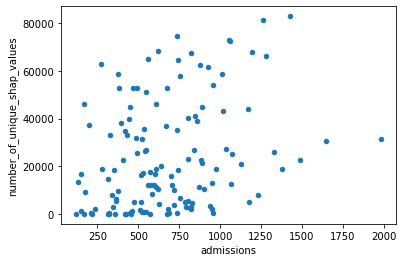

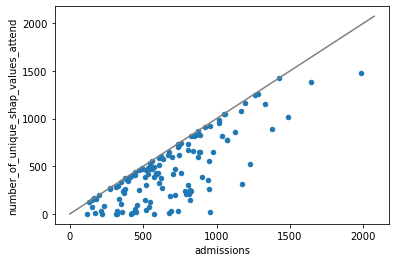

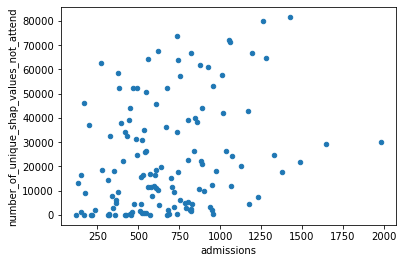

In [32]:
# Plot 1: Admissions vs number of unique SHAP values
#   All instances contributing to SHAP value count
df_hospital_details.plot.scatter(x="admissions", 
                                 y="number_of_unique_shap_values")

# Plot 2: Admissions vs number of unique SHAP values
#   Only instances that attend hosptial contributing to SHAP value count
ax = df_hospital_details.plot.scatter(x="admissions", 
                                      y="number_of_unique_shap_values_attend")
# Include x = y line (shows the max number of of unique values)
max_axis_value = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([0, max_axis_value], [0, max_axis_value], c='0.5')

# Plot 3: Admissions vs number of unique SHAP values
#   Only instances that do not attend hosptial contributing to SHAP value count
df_hospital_details.plot.scatter(x="admissions",
                                 y="number_of_unique_shap_values_not_attend")

Let's look at a hospital with the most unique values

In [33]:
row_index = df_hospital_details["number_of_unique_shap_values"].idxmax()
stroke_team_max_n_unique = df_hospital_details["Stroke team"].iloc[row_index]
print(f"Hospital {stroke_team_max_n_unique} has "
      f"{df_hospital_details['number_of_unique_shap_values'].max()} "
      f"unique values")

Hospital AKCGO9726K has 82921 unique values


Look at descriptive stats for this hospital

In [34]:
df_hosp_shap_values[stroke_team_max_n_unique].describe()

count    88792.000000
mean        -0.002248
std          0.082680
min         -0.294640
25%         -0.015132
50%         -0.008884
75%         -0.003960
max          2.055953
Name: AKCGO9726K, dtype: float64

What's the difference between the SHAP value for this hospital for the instances that attended it, compared to those instances that didn't?

Colour histogram bars to represent: Green for positive SHAP value, Grey for 0, and Red for negative SHAP value.

In [35]:
def create_histogram_with_colours(data, bins, ax):

    """
    data [DataFrame]: Single column of data containing values in the histogram
    bins [int]: Width of each histogram bar
    ax [object]: Matplotlib axes object
    
    Histogram bars are:
        green if positive value
        black if spans zero
        red if negative value
    
    Function return matplotlib axes object
    """
    
    N, bins, patches = ax.hist(data, edgecolor='white', linewidth=0.2, 
                               bins=bins);

    for i in range(N.shape[0]):
        if bins[i] < 0 and bins[i+1] < 0:
                patches[i].set_facecolor('red')
        elif bins[i] > 0 and bins[i+1] > 0:
                patches[i].set_facecolor('green')
        else:
            patches[i].set_facecolor('black')

    return(ax)

AKCGO9726K. Number of unique values for all patients (attended or not): 82921
Number of patients 88792
AKCGO9726K. Number of unique values for those patients who attended: 1421
Number of patients 1428
AKCGO9726K. Number of unique values for those patients who do not attended: 81500
Number of patients 87364


<function matplotlib.pyplot.show(close=None, block=None)>

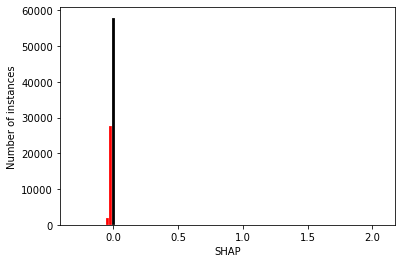

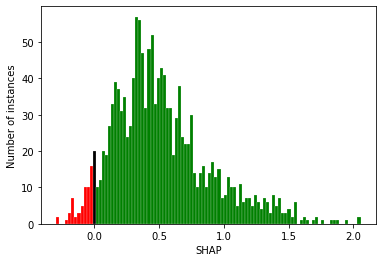

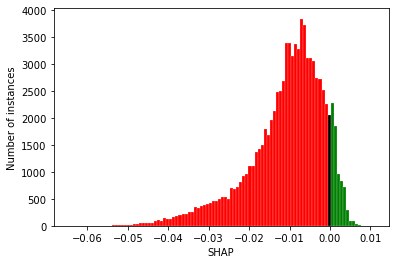

In [36]:
stroke_team = stroke_team_max_n_unique

mask1 = df_hosp_shap_values["Stroke team"] == stroke_team
shap_values_attend = df_hosp_shap_values[stroke_team][mask1]

mask2 = np.logical_not(mask1)
shap_values_not_attend = df_hosp_shap_values[stroke_team][mask2]

# Plot histogram of SHAP values for all instances
fig, ax = plt.subplots()
create_histogram_with_colours(df_hosp_shap_values[stroke_team], 100, ax)
ax.set_xlabel(f"SHAP")
ax.set_ylabel("Number of instances")
print(f"{stroke_team}. Number of unique values for all patients (attended or "
      f"not): {df_hosp_shap_values[stroke_team].nunique()}")
print(f"Number of patients {df_hosp_shap_values[stroke_team].shape[0]}")
plt.show

# Plot histogram of SHAP values for instances attend hospital
mask1 = mask1 * 1
s1 = mask1.sum()
fig, ax = plt.subplots()
ax = create_histogram_with_colours(shap_values_attend, 100, ax)
ax.set_xlabel(f"SHAP")
ax.set_ylabel("Number of instances")
print(f"{stroke_team}. Number of unique values for those patients who "
      f"attended: {shap_values_attend.nunique()}")
print(f"Number of patients {s1}")
plt.show

# Plot histogram of SHAP values for instances not attend hospital
mask2 = mask2 * 1
s2 = mask2.sum()
fig, ax = plt.subplots()
ax = create_histogram_with_colours(shap_values_not_attend, 100, ax)
ax.set_xlabel(f"SHAP")
ax.set_ylabel("Number of instances")
print(f"{stroke_team}. Number of unique values for those patients who do not "
      f"attended: {shap_values_not_attend.nunique()}")
print(f"Number of patients {s2}")
plt.show


So there's two populations, but in the top plot you can not see the histogram for the instances that attended the hospital, as their frequency is too few and the plot is dominated by the frequency range for the number of patients who did not attend the hosptial.

Those that attend have a higher SHAP value, but there's fewer instances so can not see these values.
Those that do not attend have a low SHAP value, a smaller range of values, but far more instances, so dominates the y axis, but can not see the spread (as the other population has determines the x axis range).

Better to view as two populations.

Plot a boxplot for the SHAP values of each hospital (for all instances)

In [37]:
# Create list of values for each boxplot (one per hospital)
stroketeam_groups = []
for h in hospital_names:
    stroketeam_groups.append(df_hosp_shap_values[h])

Shows the range of contributions to the prediction from this hospital for all the instances


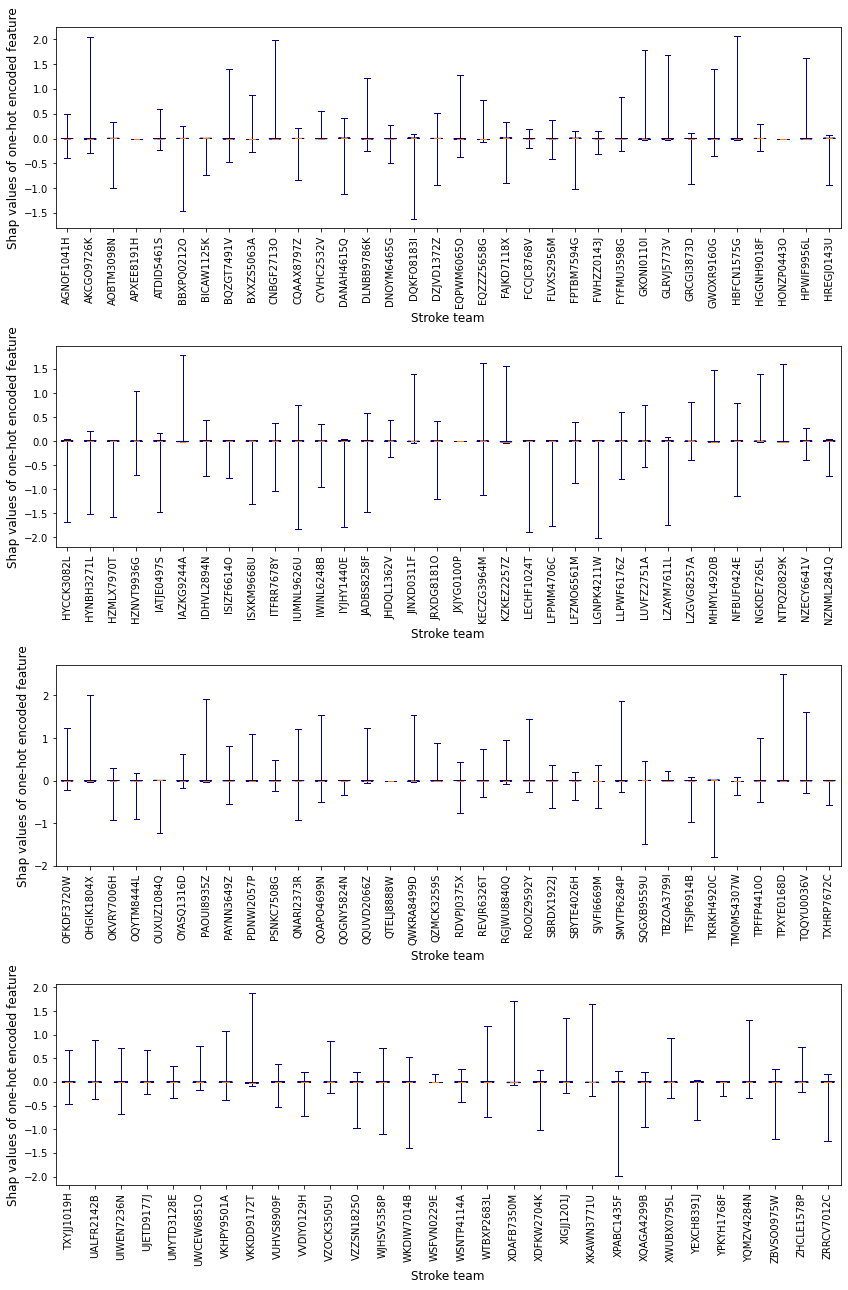

In [38]:
# Create a figure with 35 hospitals in each to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "for all the instances")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Plot properties
c1 = "navy"
c2 = "navy"
c3 = "white"

# Create figure with 4 subplots
fig = plt.figure(figsize=(12,18))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)
    ax.boxplot(stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=9999999, patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                meanprops=dict(color=c2))
    plt.ylabel('Shap values of one-hot encoded feature',size=12)
    plt.xlabel('Stroke team',size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)
    
plt.subplots_adjust(bottom=0.25, wspace=0.05)
plt.tight_layout(pad=2)
plt.show()

Shows that hospitals have the majority of their cases at value 0, and some have a longer range than others, with most having their range entirely on one side of 0 or the other.

Let's plot it again, twice, showing only those instances that go to the hospital, and again when they do not.

Include instances that attend the hospital only

In [39]:
# Create list of values for each boxplot (one per hospital), only include SHAP 
#   value for instances that attend stroke team
attend_stroketeam_groups = []
for h in hospital_names:
    mask = df_hosp_shap_values['Stroke team'] == h
    attend_stroketeam_groups.append(df_hosp_shap_values[h][mask])

Shows the range of contributions to the prediction from this hospital when patients attend this hosptial


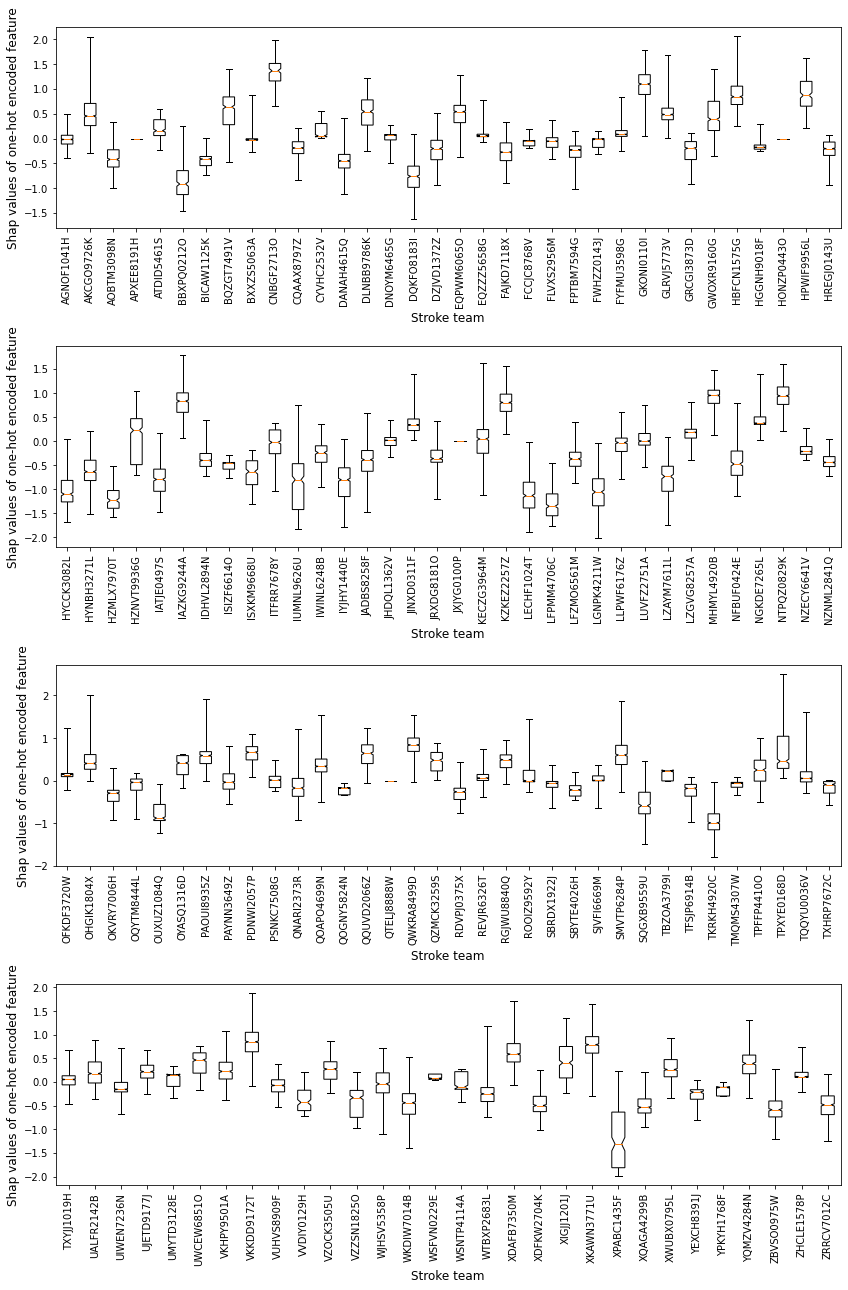

In [40]:
# Create a figure with 35 hospitals in each to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Plot properties
c1 = "black"
c2 = "black"
c3 = "white"

# Create figure with 4 subplots
fig = plt.figure(figsize=(12,18))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)
        
    ax.boxplot(attend_stroketeam_groups[st:ed],
               labels=df_hosp_shap_values.columns[st:ed],
               whis=999999,patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               meanprops=dict(color=c2))

    plt.ylabel('Shap values of one-hot encoded feature',size=12)
    plt.xlabel('Stroke team',size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)
    
plt.subplots_adjust(bottom=0.25, wspace=0.05)
plt.tight_layout(pad=2)
plt.show()

Edit data so only contains instances when not go to hospital

In [41]:
# Only include SHAP value for instances that do not attend stroke team
not_attend_stroketeam_groups = []
for h in hospital_names:
    mask = df_hosp_shap_values['Stroke team'] != h
    not_attend_stroketeam_groups.append(df_hosp_shap_values[h][mask])

Shows the range of contributions to the prediction from this hospital when patients do not attend this hosptial


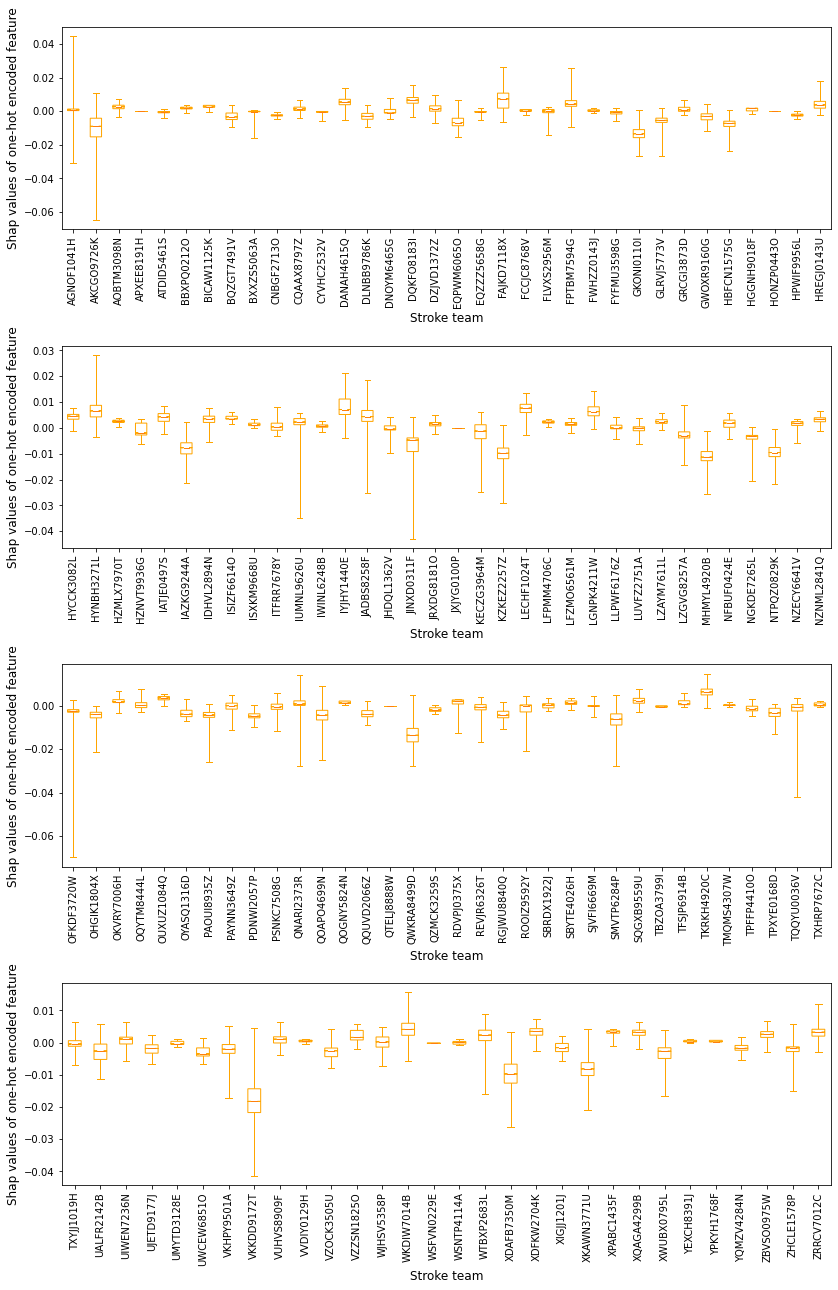

In [42]:
# Create a figure with 35 hospitals in each to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients do not attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Plot properties
c1 = "orange"
c2 = "orange"
c3 = "white"
 
# Create figure with 4 subplots
fig = plt.figure(figsize=(12,18))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)

    ax.boxplot(not_attend_stroketeam_groups[st:ed],
               labels=df_hosp_shap_values.columns[st:ed],
               whis=999999,patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               meanprops=dict(color=c2))
        
    plt.ylabel('Shap values of one-hot encoded feature',size=12)
    plt.xlabel('Stroke team',size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)
    
plt.subplots_adjust(bottom=0.25, wspace=0.05)
plt.tight_layout(pad=2)
plt.show()

Shows the range of contributions to the prediction from this hospital when patients 1) do [black], and 2) do not [orange] attend this hosptial


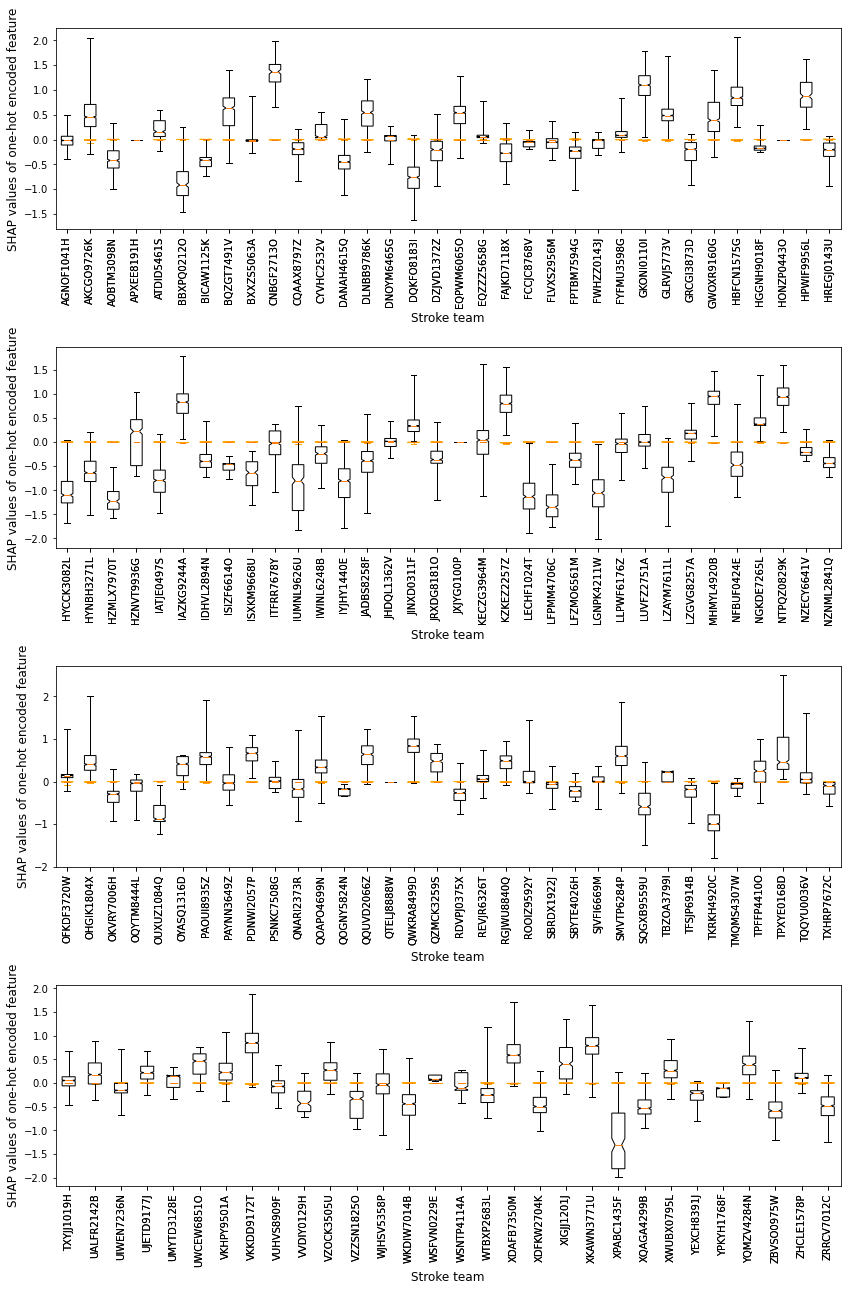

In [43]:
# Two box plots on 1 plot (spread of SHAP when instance attend, and not attend, 
#   hospital)

# Create a figure with 35 hospitals in each to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients 1) do [black], and 2) do not [orange] attend this "
      "hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Create figure with 4 subplots
fig = plt.figure(figsize=(12,18))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)

    # The contribution from this hospital when patients do not attend this 
    #   hosptial
    c1 = "orange"
    c2 = "orange"
    c3 = "white"
    ax.boxplot(not_attend_stroketeam_groups[st:ed],
               labels=df_hosp_shap_values.columns[st:ed],
               whis=99999,patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               meanprops=dict(color=c2))
        
    # The contribution from this hospital when patients do attend this hosptial
    c1 = "black"
    c2 = "black"
    c3 = "white"
    ax.boxplot(attend_stroketeam_groups[st:ed],
               labels=df_hosp_shap_values.columns[st:ed],
               whis=99999,patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               meanprops=dict(color=c2))

    plt.ylabel('SHAP values of one-hot encoded feature',size=12)
    plt.xlabel('Stroke team',size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

plt.subplots_adjust(bottom=0.25, wspace=0.05)
plt.tight_layout(pad=2)
plt.show()

Does it help understanding to represent this as histograms?

Create three matrix of histograms. 

* One with all the instances to each hosptial
* One with just the instances that attend each hosptial
* One with just the instances that don't attend each hosptial.

One with all the instances to each hosptial (forcing same axis ranges)

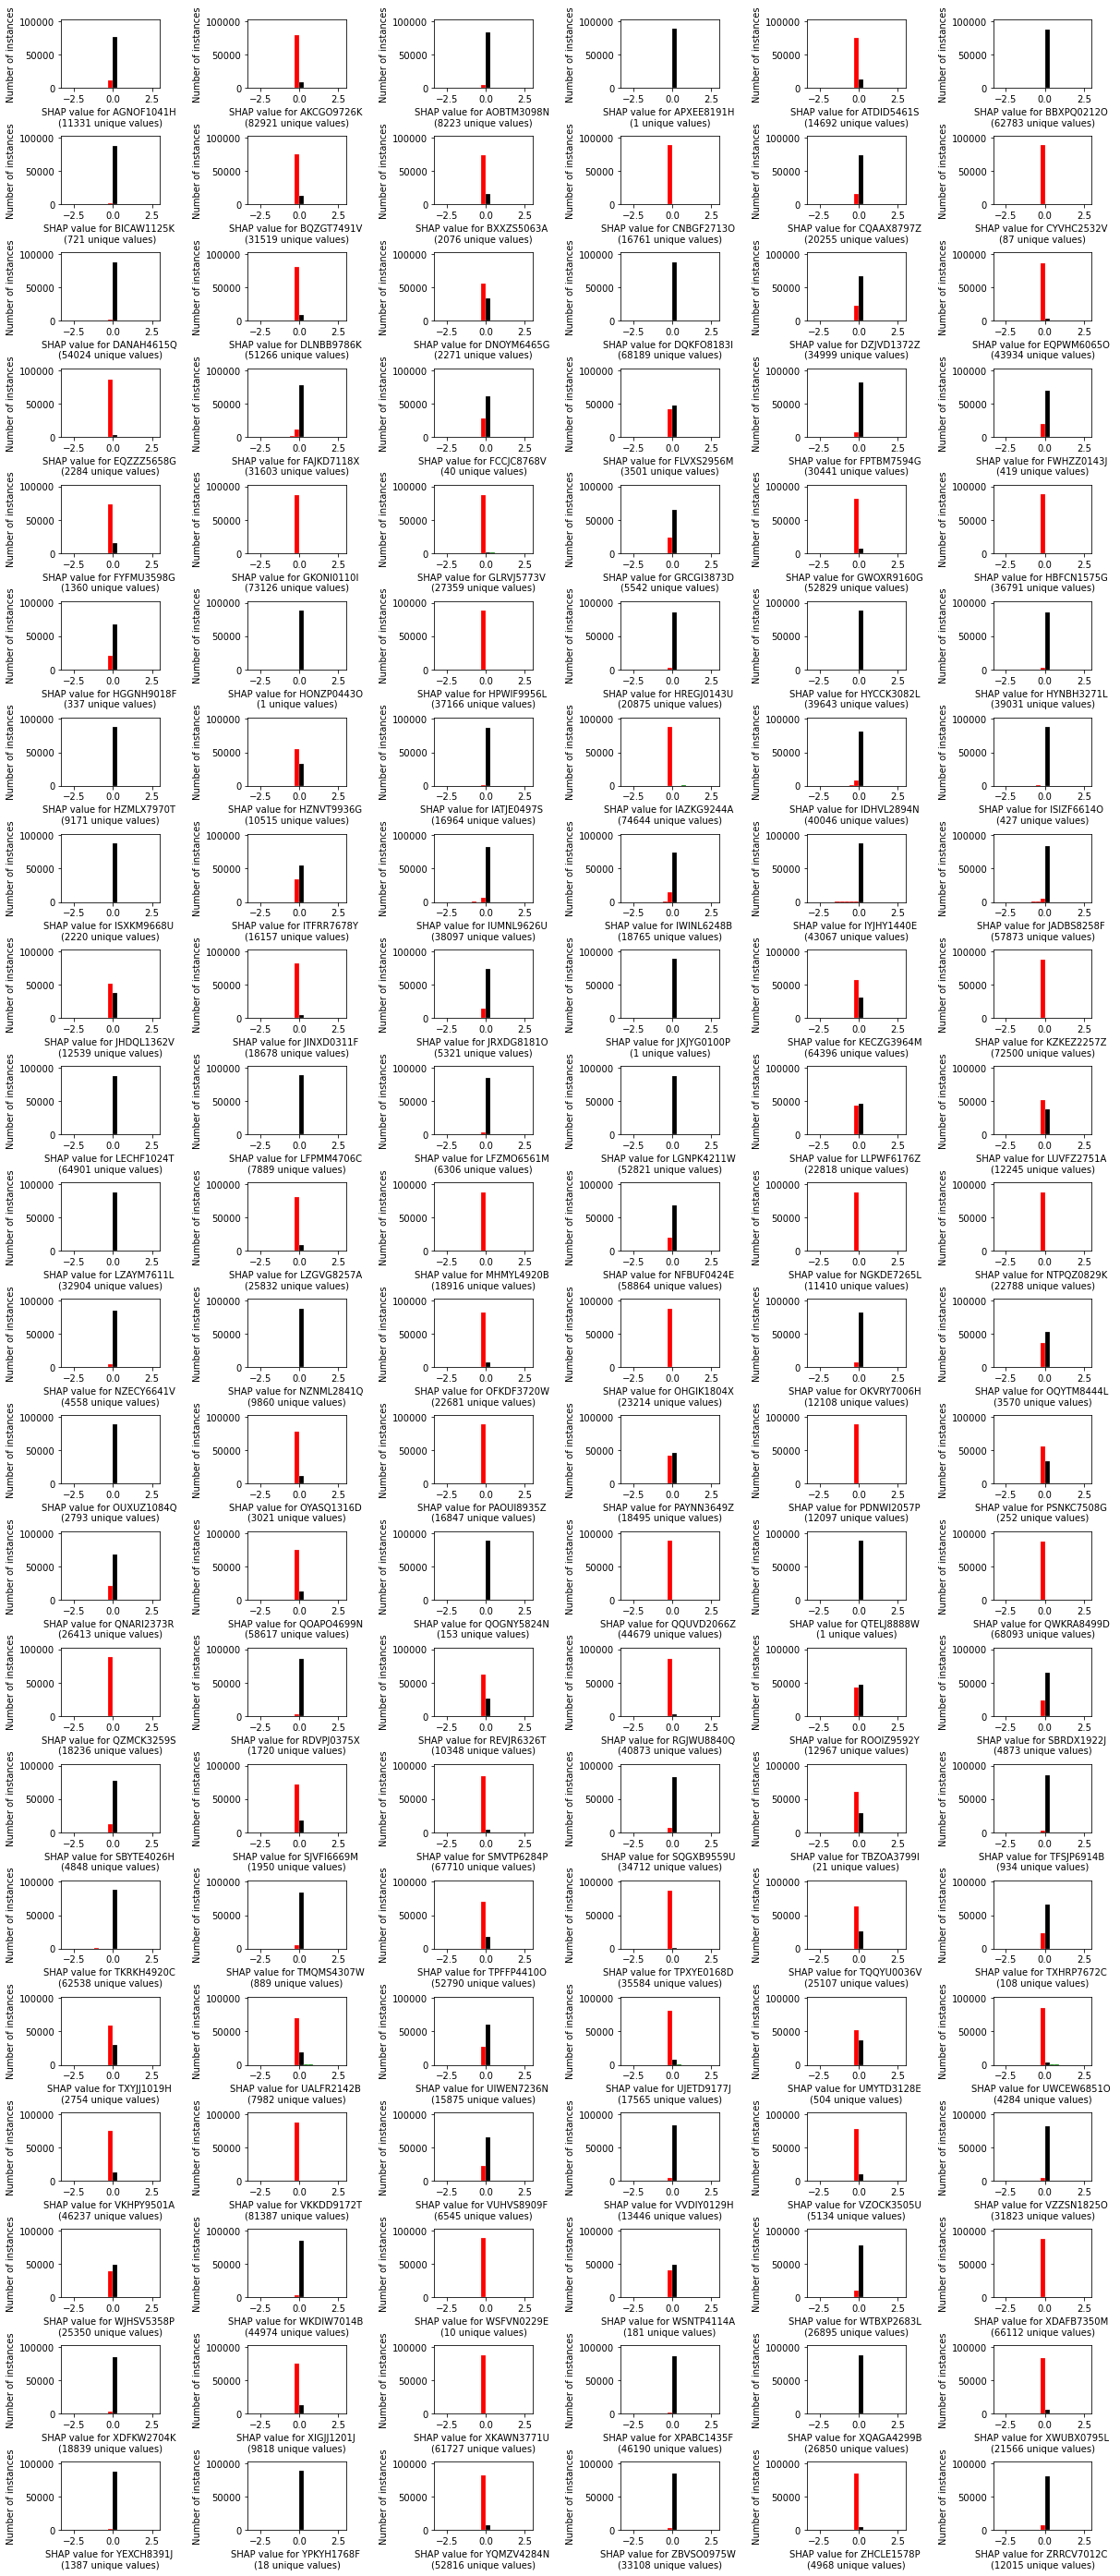

In [44]:
# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
x_min = 99
x_max = -99
fig, axes = plt.subplots(1)
for h in hospital_names:
    # Plot histogram
    axes.hist(df_hosp_shap_values[h])
    # Get axis limits
    ylims = axes.get_ylim()
    # Store if greater than found so far
    y_max = max(y_max, ylims[1])
    # Get axis limits
    xlims = axes.get_xlim()
    # Store if greater than found so far
    x_min = min(x_min, xlims[0])
    x_max = max(x_max, xlims[1])
# Don't display plot
plt.close(fig)

# Define width of histogram bins based on the x axis range
bin_width = (abs(math.floor(xlims[0])) + abs(math.ceil(xlims[1])))/20

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for h in hospital_names:
    n_unique = df_hosp_shap_values[h].nunique()
    ax=axes[count]
    create_histogram_with_colours(df_hosp_shap_values[h],
            np.arange(math.floor(xlims[0]),math.ceil(xlims[1]),bin_width),
            ax)
    ax.set_xlabel(f"SHAP value for {h} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances")
    ax.set_ylim(0, (y_max*1.1))
    count += 1

# Define figure display
fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

One with just the instances that attend each hosptial

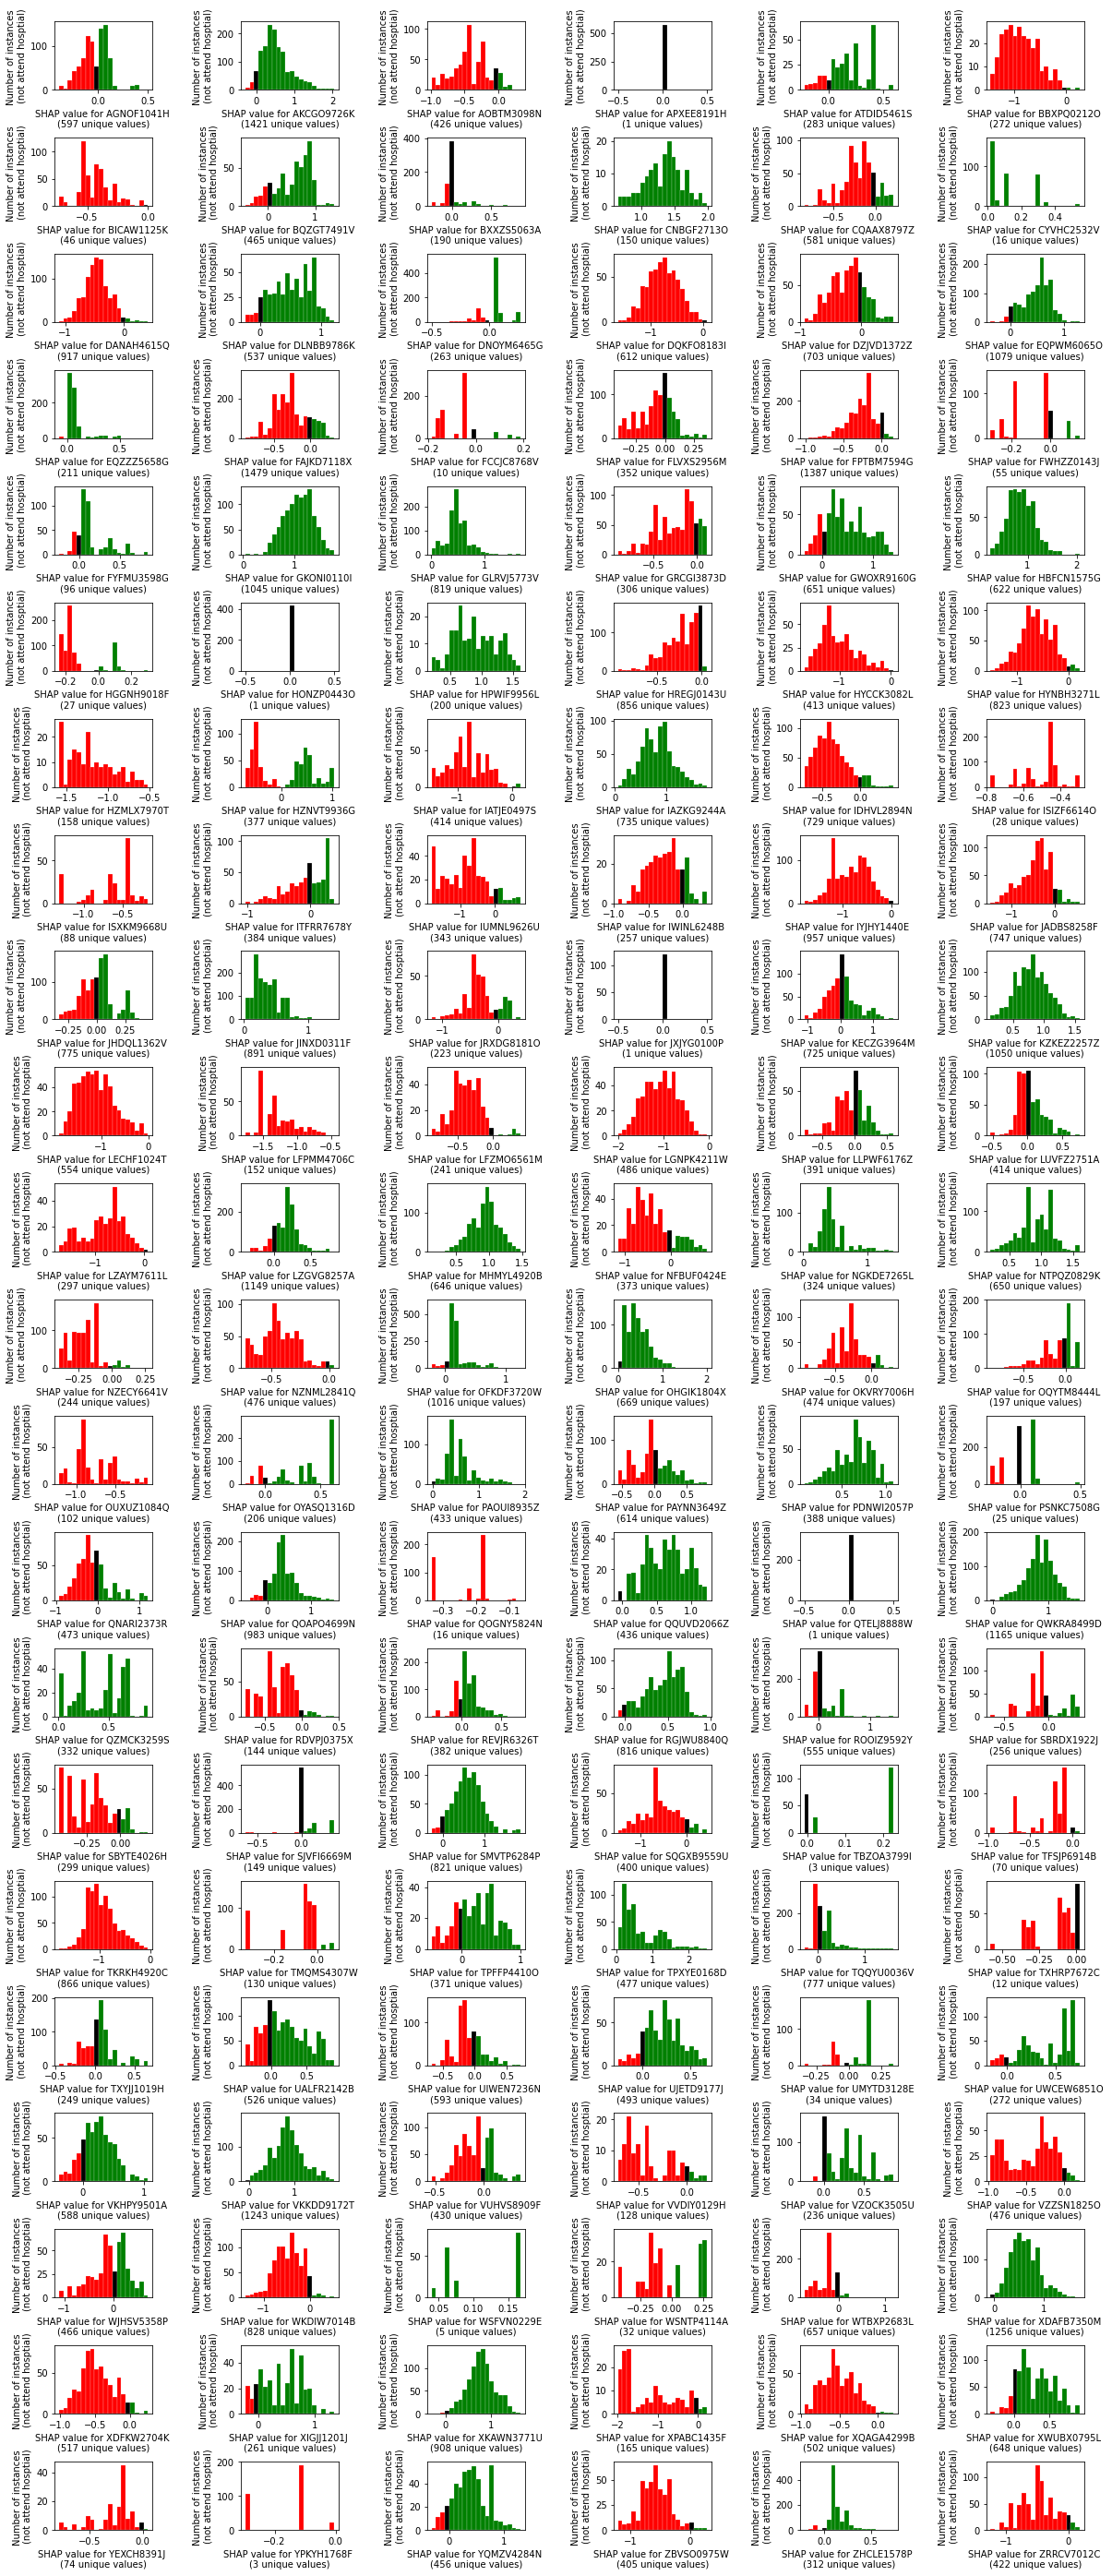

In [45]:
# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for h in hospital_names:
    mask = X_combined["Stroke team"] == h #drop "team_"
    shap_values_not_attend = df_hosp_shap_values[h][mask]
    n_unique = shap_values_not_attend.nunique()
    ax=axes[count]
    create_histogram_with_colours(shap_values_not_attend, 20, ax)
#    ax.hist(shap_values_not_attend, bins=20)
    ax.set_xlabel(f"SHAP value for {h} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances \n(not attend hosptial)")
#    ax.set_ylim(0, y_max)
#    ax.set_xlim(x_min, x_max)
    count += 1

fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

One with just the instances that don't attend each hosptial.

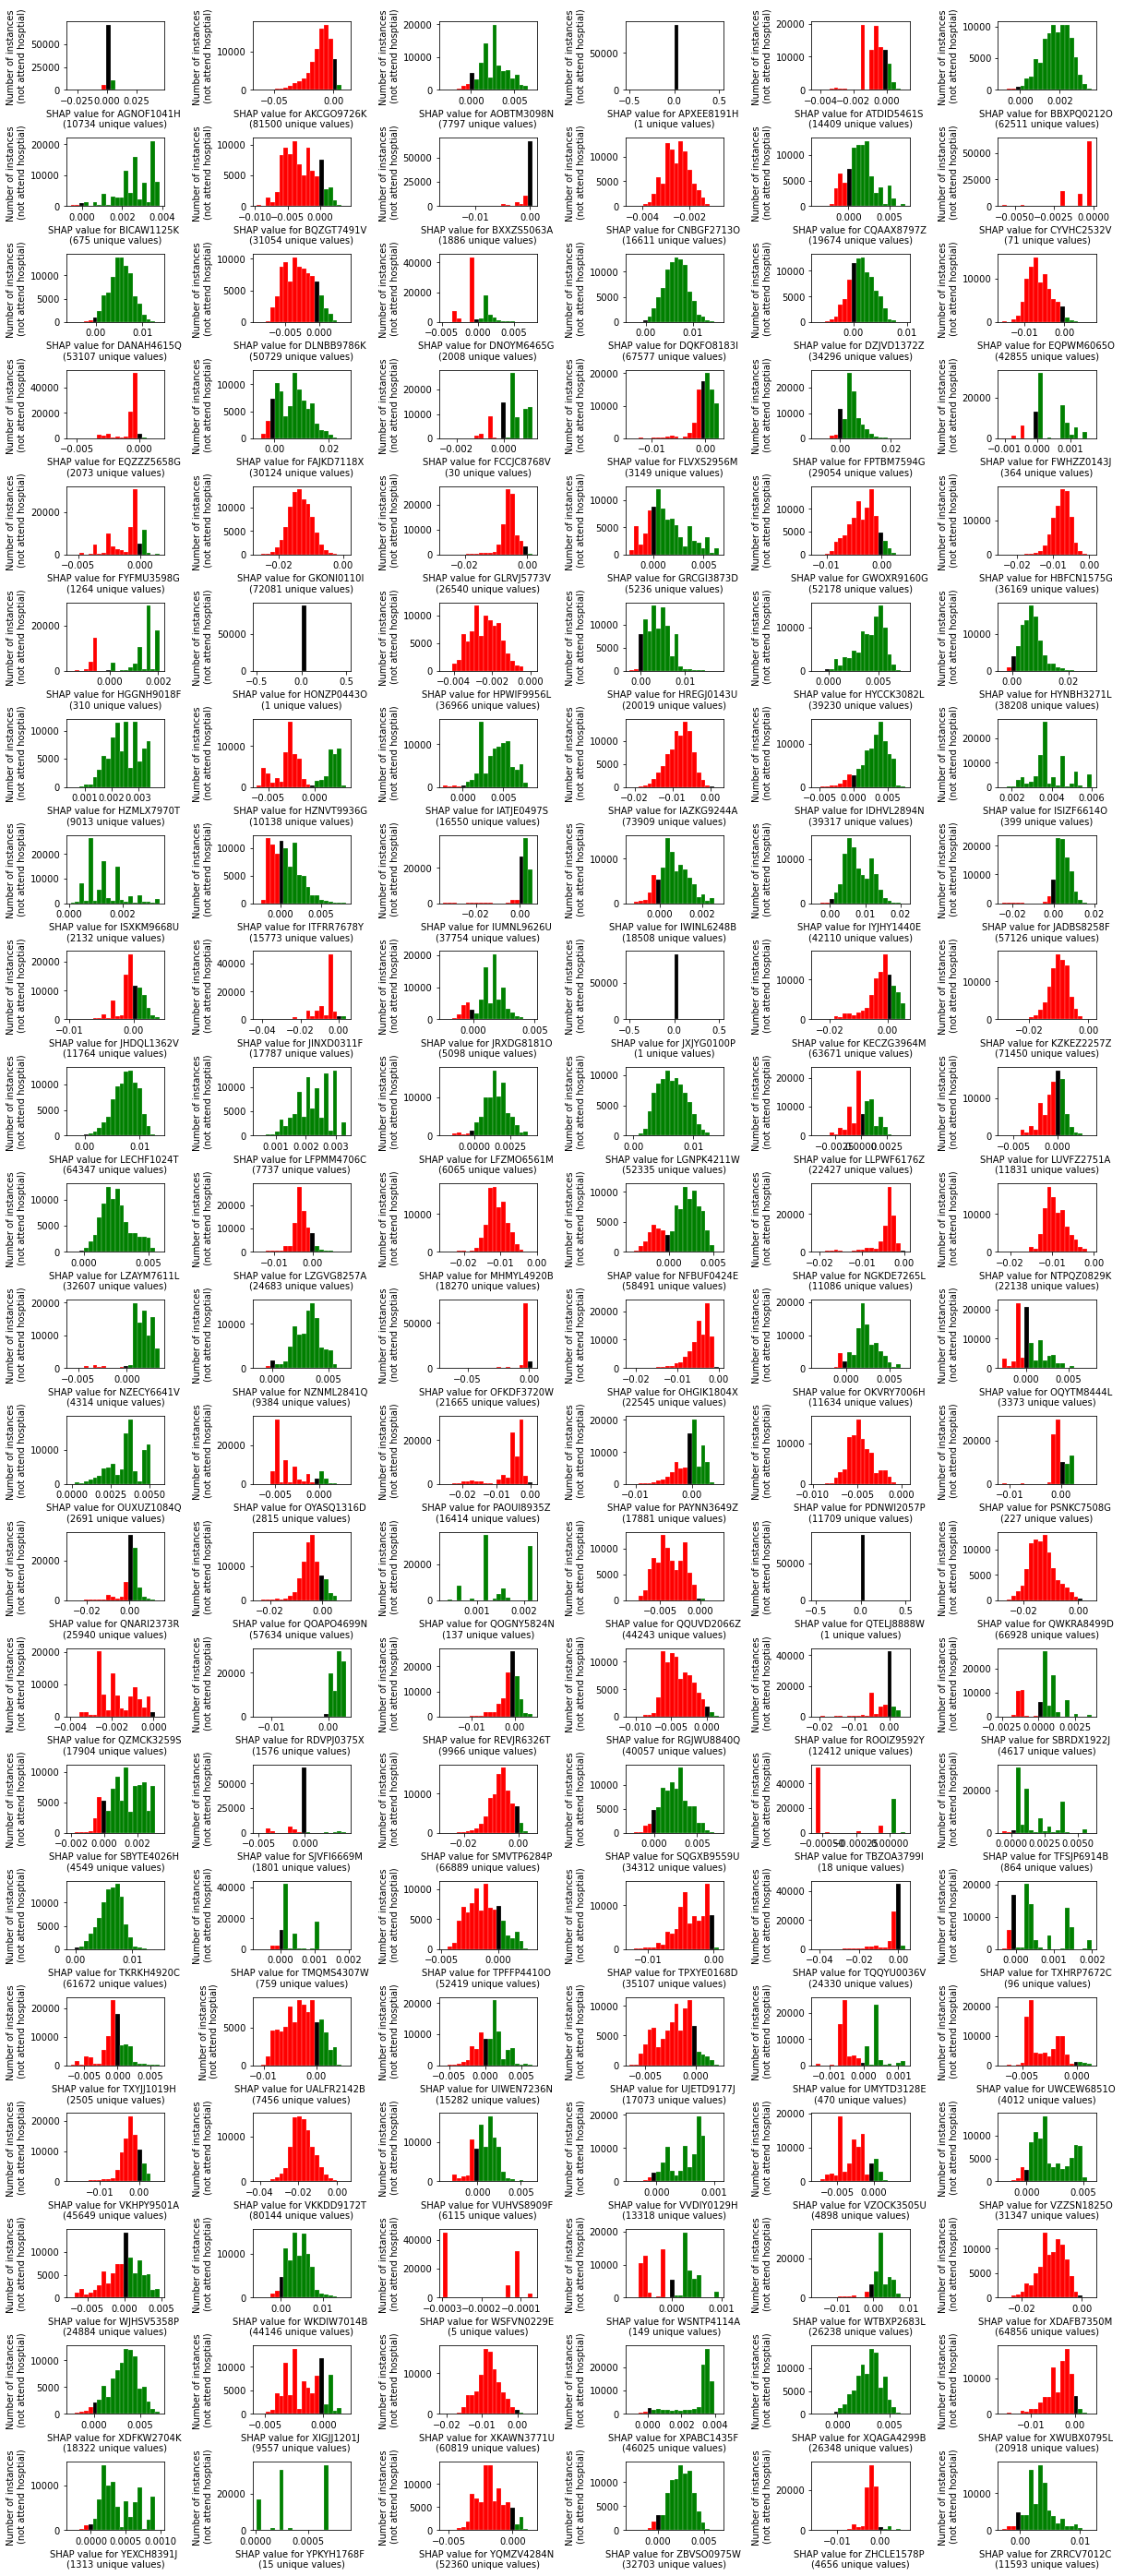

In [46]:
# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for h in hospital_names:
    mask = X_combined["Stroke team"] == h #drop "team_"
    mask = np.logical_not(mask)# Those that didn't attend
    shap_values_not_attend = df_hosp_shap_values[h][mask]
    n_unique = shap_values_not_attend.nunique()
    ax=axes[count]
    create_histogram_with_colours(shap_values_not_attend, 20, ax)
#    ax.hist(shap_values_not_attend, bins=20)
    ax.set_xlabel(f"SHAP value for {h} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances \n(not attend hosptial)")
#    ax.set_ylim(0, y_max)
#    ax.set_xlim(x_min, x_max)
    count += 1

fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

Code showing the same histograms, with each having the same x axis range and y axis range

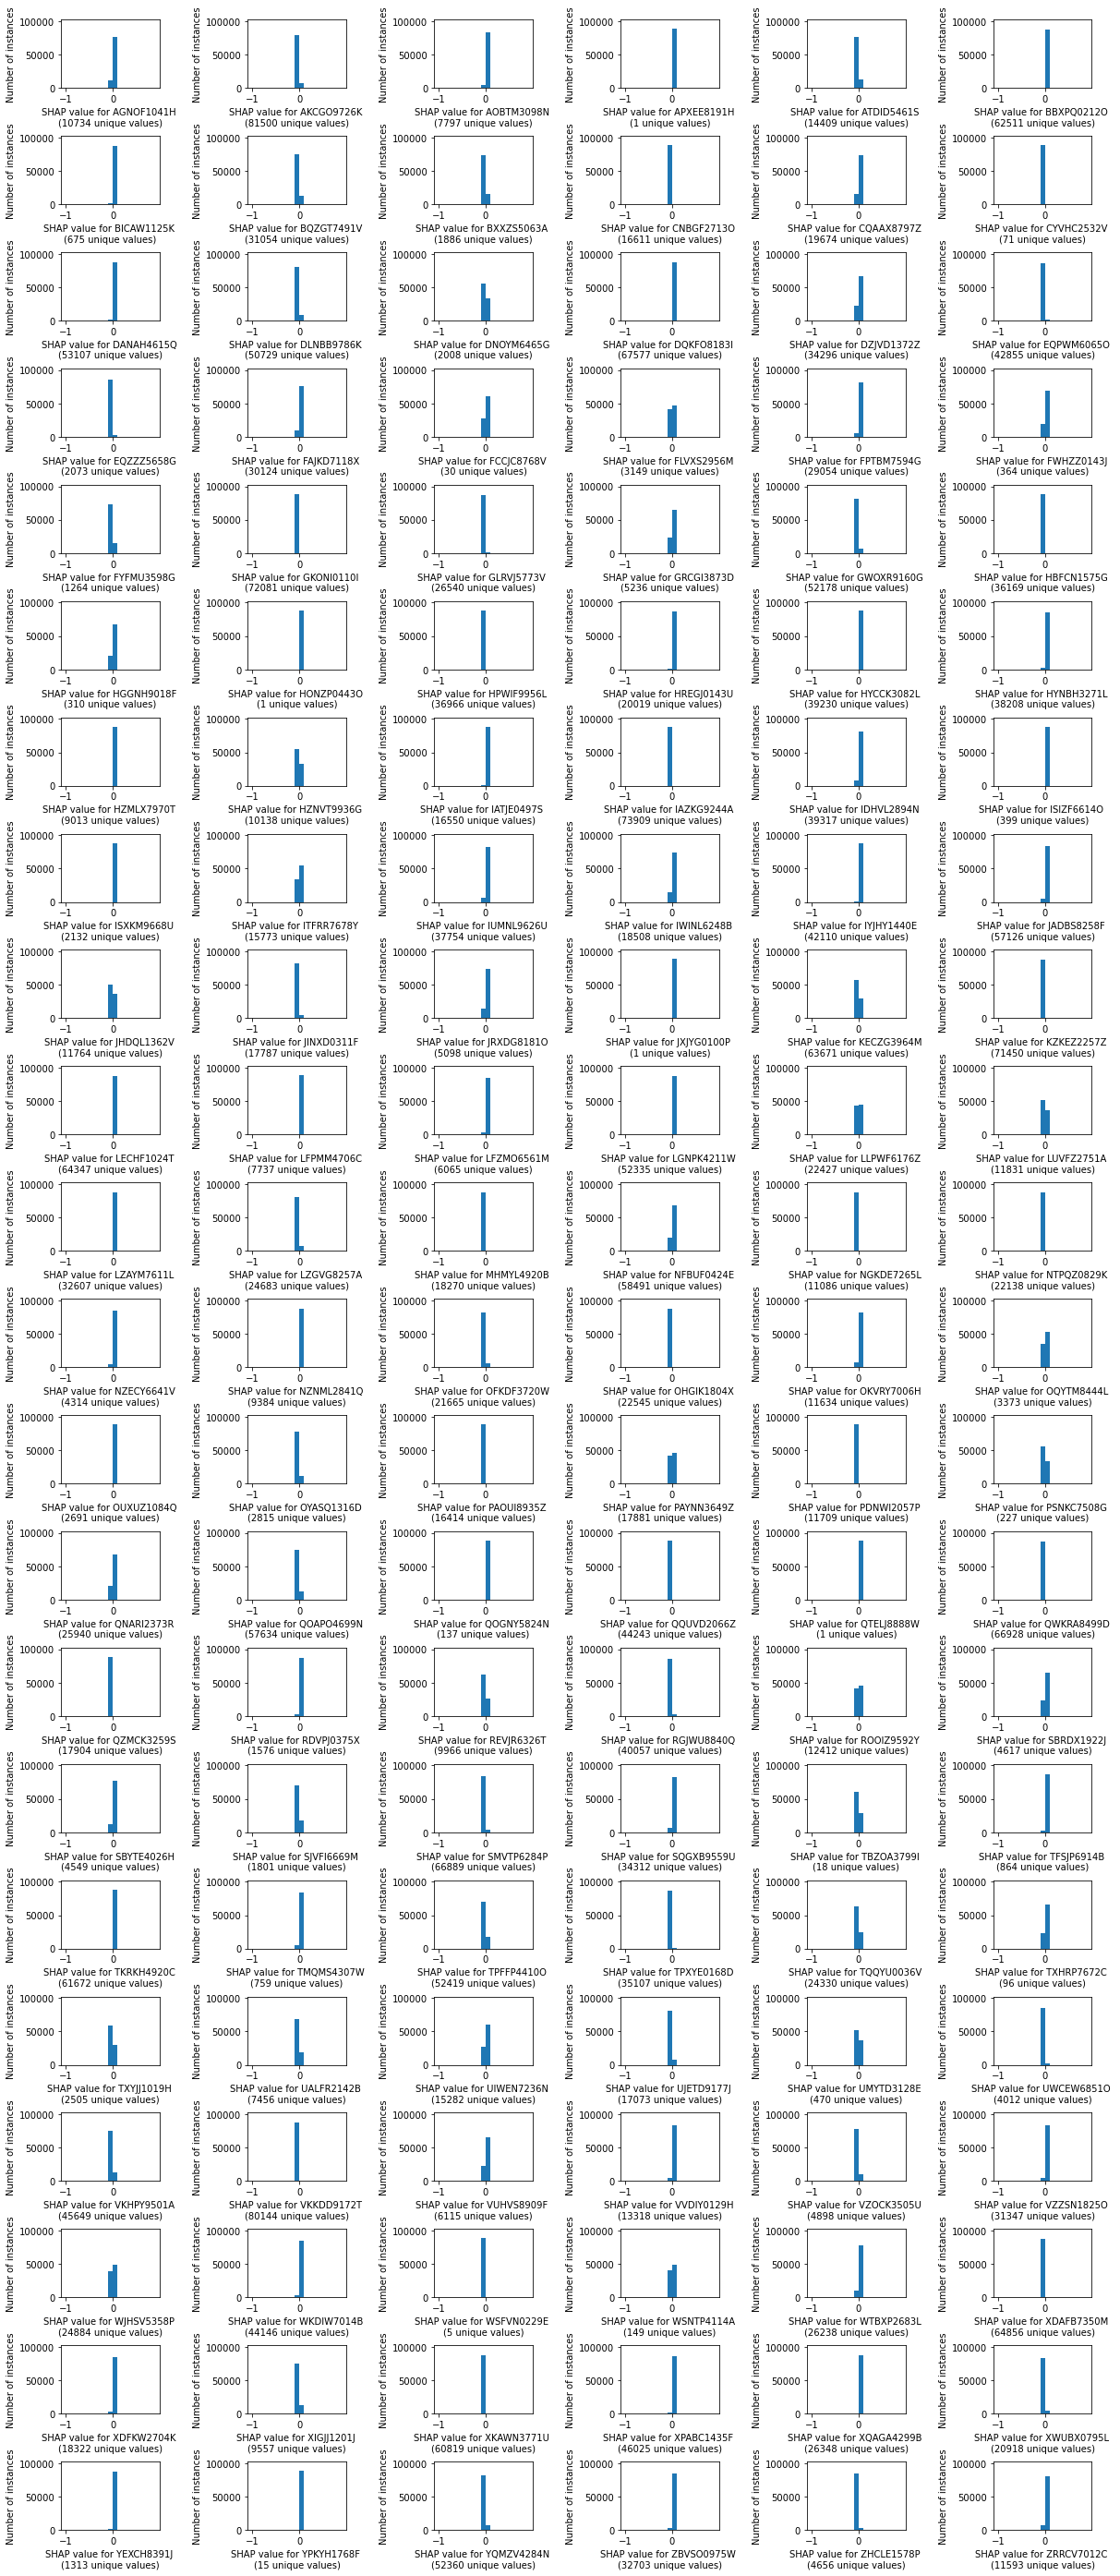

In [47]:
# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
x_min = 99
x_max = -99
fig, axes = plt.subplots(1)
for h in hospital_names:
    # mask data for those that attend hospital
    mask = df_hosp_shap_values["Stroke team"] == h
    # Those that didn't attend
    mask = np.logical_not(mask)
    shap_values_attend = df_hosp_shap_values[h][mask]
    n_unique = shap_values_attend.nunique()
    # Plot histogram
    axes.hist(shap_values_attend)
    # Get axis limits
    ylims = axes.get_ylim()
    # Store if greater than found so far
    y_max = max(y_max, ylims[1])
    # Get axis limits
    xlims = axes.get_xlim()
    # Store if greater than found so far
    x_min = min(x_min, xlims[0])
    x_max = max(x_max, xlims[1])
# Don't display plot
plt.close(fig)

# Define width of histogram bins based on the x axis range
bin_width = (abs(math.floor(xlims[0])) + abs(math.ceil(xlims[1])))/20

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for h in hospital_names:
    # mask data for those that attend hospital
    mask = df_hosp_shap_values["Stroke team"] == h
    # Those that didn't attend
    mask = np.logical_not(mask)
    shap_values_attend = df_hosp_shap_values[h][mask]
    n_unique = shap_values_attend.nunique()
    # Plot histogram
    ax=axes[count]
    ax.hist(shap_values_attend, 
            bins=np.arange(math.floor(xlims[0]),math.ceil(xlims[1]),bin_width))
    ax.set_xlabel(f"SHAP value for {h} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances")
    ax.set_ylim(0, (y_max*1.1))
    count += 1

# Define figure display
fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()